# Lab 4 - Working with 'real' data

## William Olsen, partners with Jennifer Vo

In this lab we are going to work on how to estimate the background from 'real' data. Real is in air quotes because the data is actually from simplified simulations to make the problems manageable in a single lab. But the data will have some features that resemble that of real data sets.

In [1]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

# this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

## Problem 1

Lets consider data from a gamma-ray satellite orbiting in low Earth orbit. This satellite records the number of particles detected every 100 milliseconds, with an orbit of approximately 90 minutes. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

### Part 1

First we will download and explore the data set.  The data has 25 million rows and 4 columns.  The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts.

Let's begin by plotting our data to gain a better understanding of its dynamics.  Once we have done this we will provide a high-level description of the features seen in the data.  Finally we will consider how we could construct a background pdf provided possible signal contamination.  We will start with four plots: a plot of the solar phase vs time, earth longitude vs time, particle counts vs time, and particle counts vs time over a longer period of time:

In [2]:
# first lets load our data
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

In [3]:
# lets split the data further into a time array and eveyrthing else
times = data[0,:]
metadata = data[1:,:]

In [4]:
# lets define variable names for our columns
solar_phase_idx = 0
earth_long_idx = 1
num_particles_idx = 2

# lets define a helper function to return us a subset of the data
def get_subset(x, y, column, start, amount):
    return x[start:min(start+amount, len(x))], y[column, start:min(start+amount, len(y[column]))]

# lets define a helper function for quick plotting
def generate_scatter_plot(x, y, ylabel):
    plt.plot(x, y, 'o')
    plt.tick_params(labelsize=24)
    plt.xlabel('Time (GPS seconds)', fontsize=24)
    plt.ylabel(ylabel, fontsize=24)

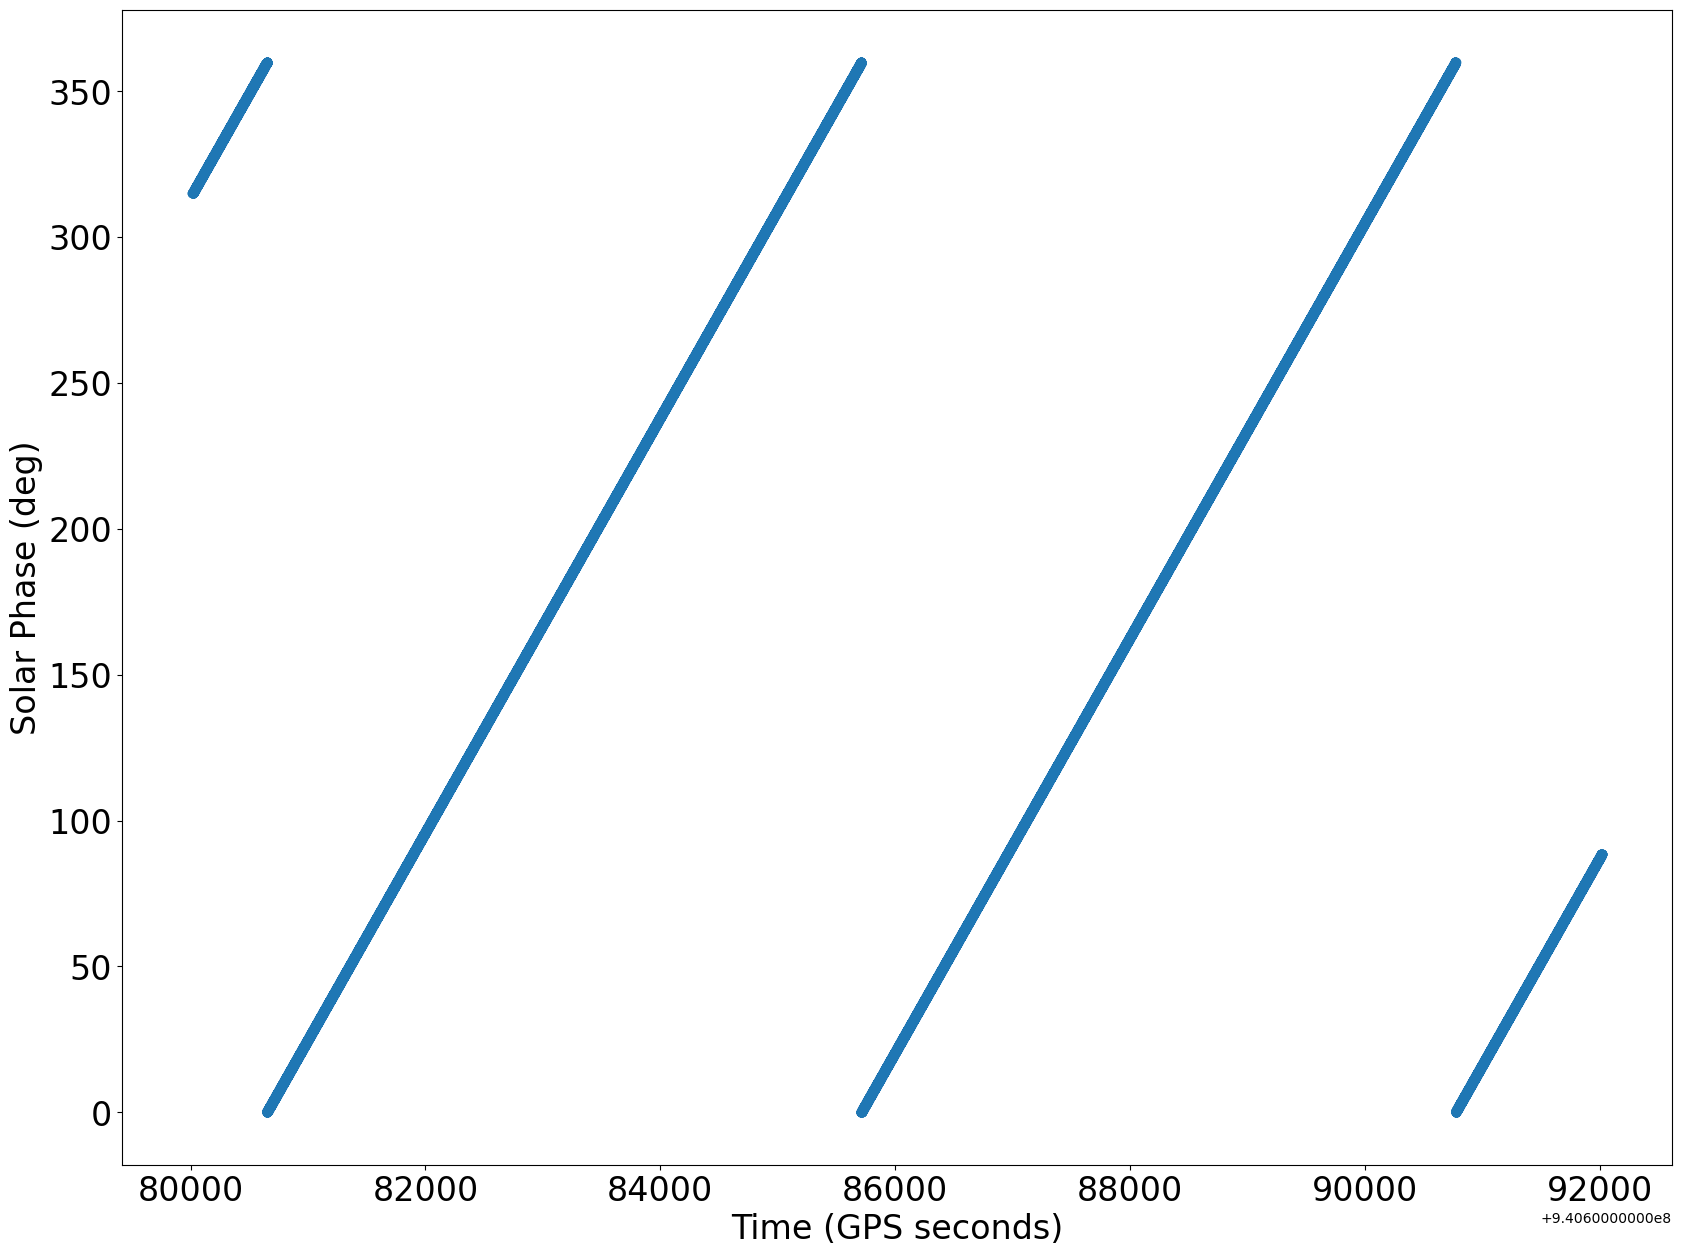

In [5]:
times_sp_1, solar_phase_1 = get_subset(times, metadata, solar_phase_idx, 0, 120000)

generate_scatter_plot(times_sp_1, solar_phase_1, 'Solar Phase (deg)')

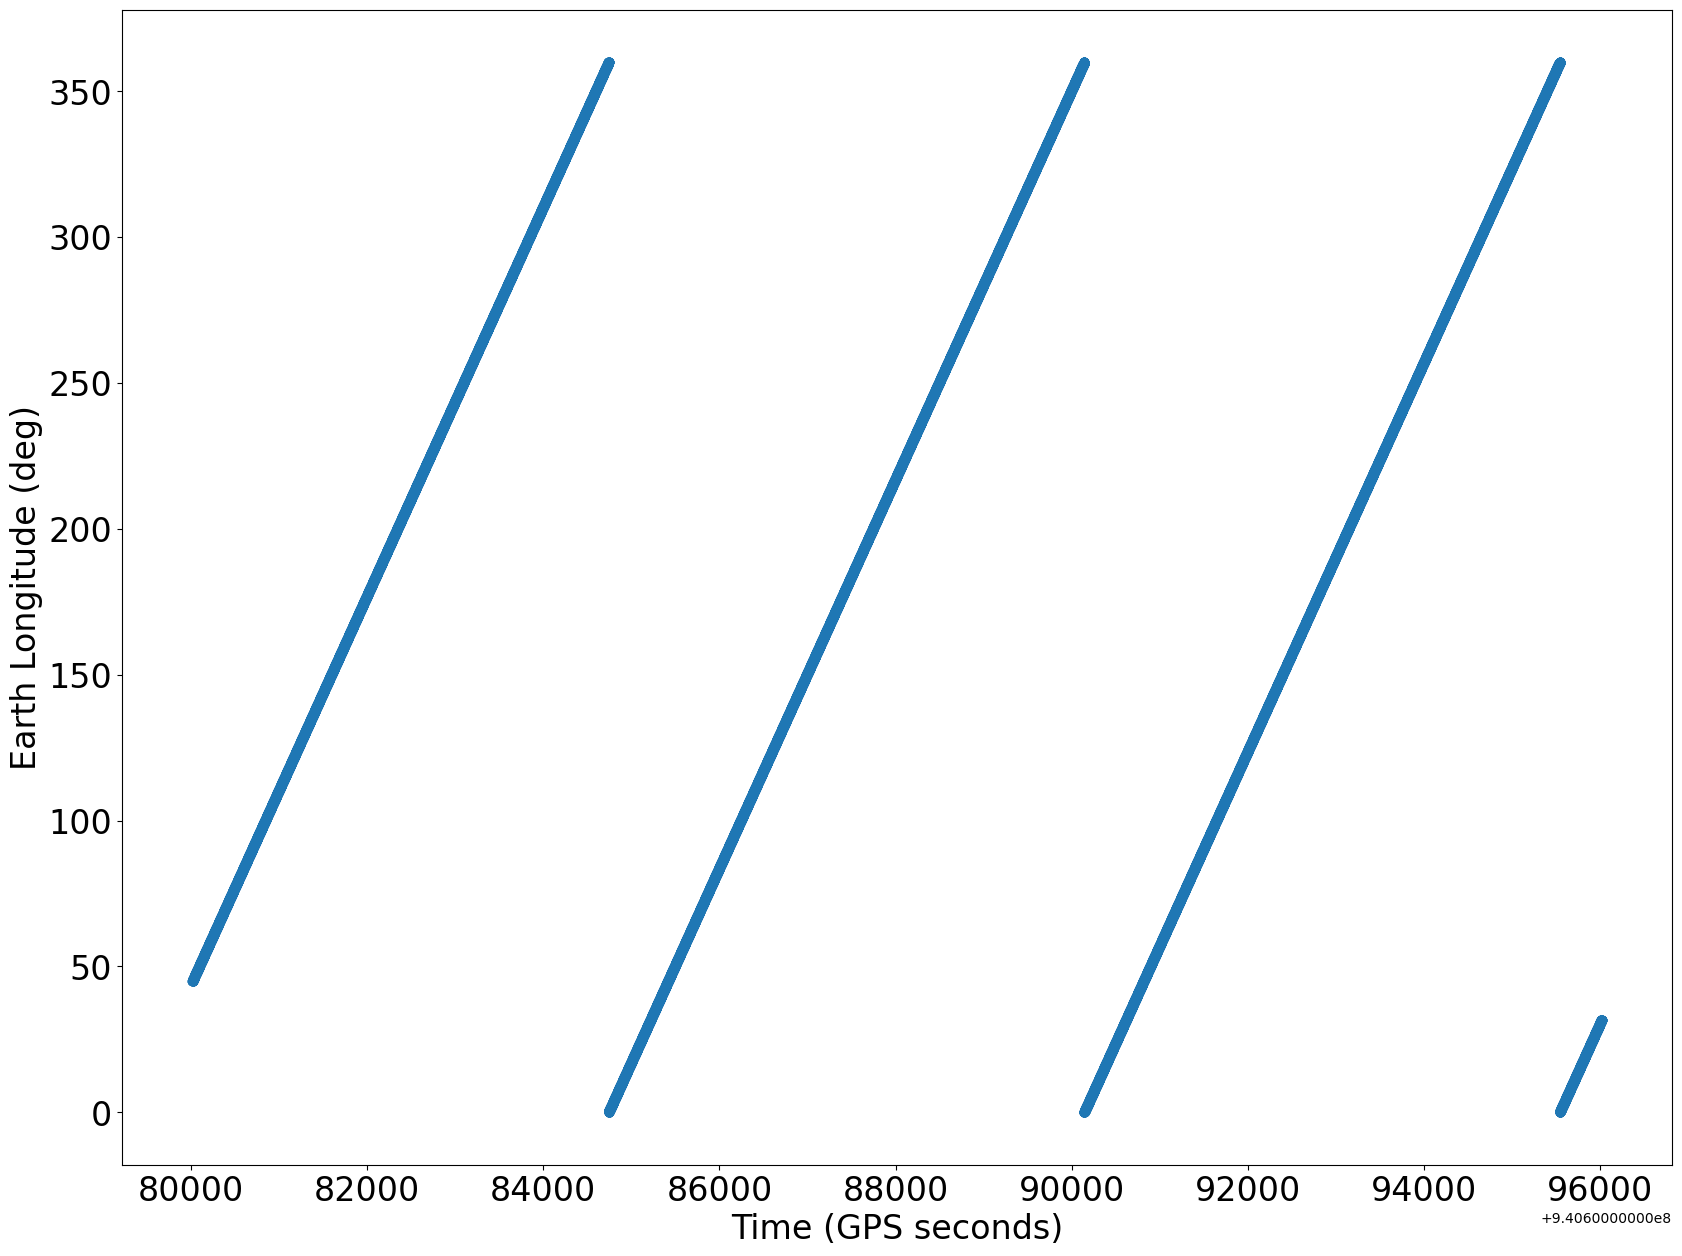

In [6]:
times_el_1, earth_long_1 = get_subset(times, metadata, earth_long_idx, 0, 160000)

generate_scatter_plot(times_el_1, earth_long_1, 'Earth Longitude (deg)')

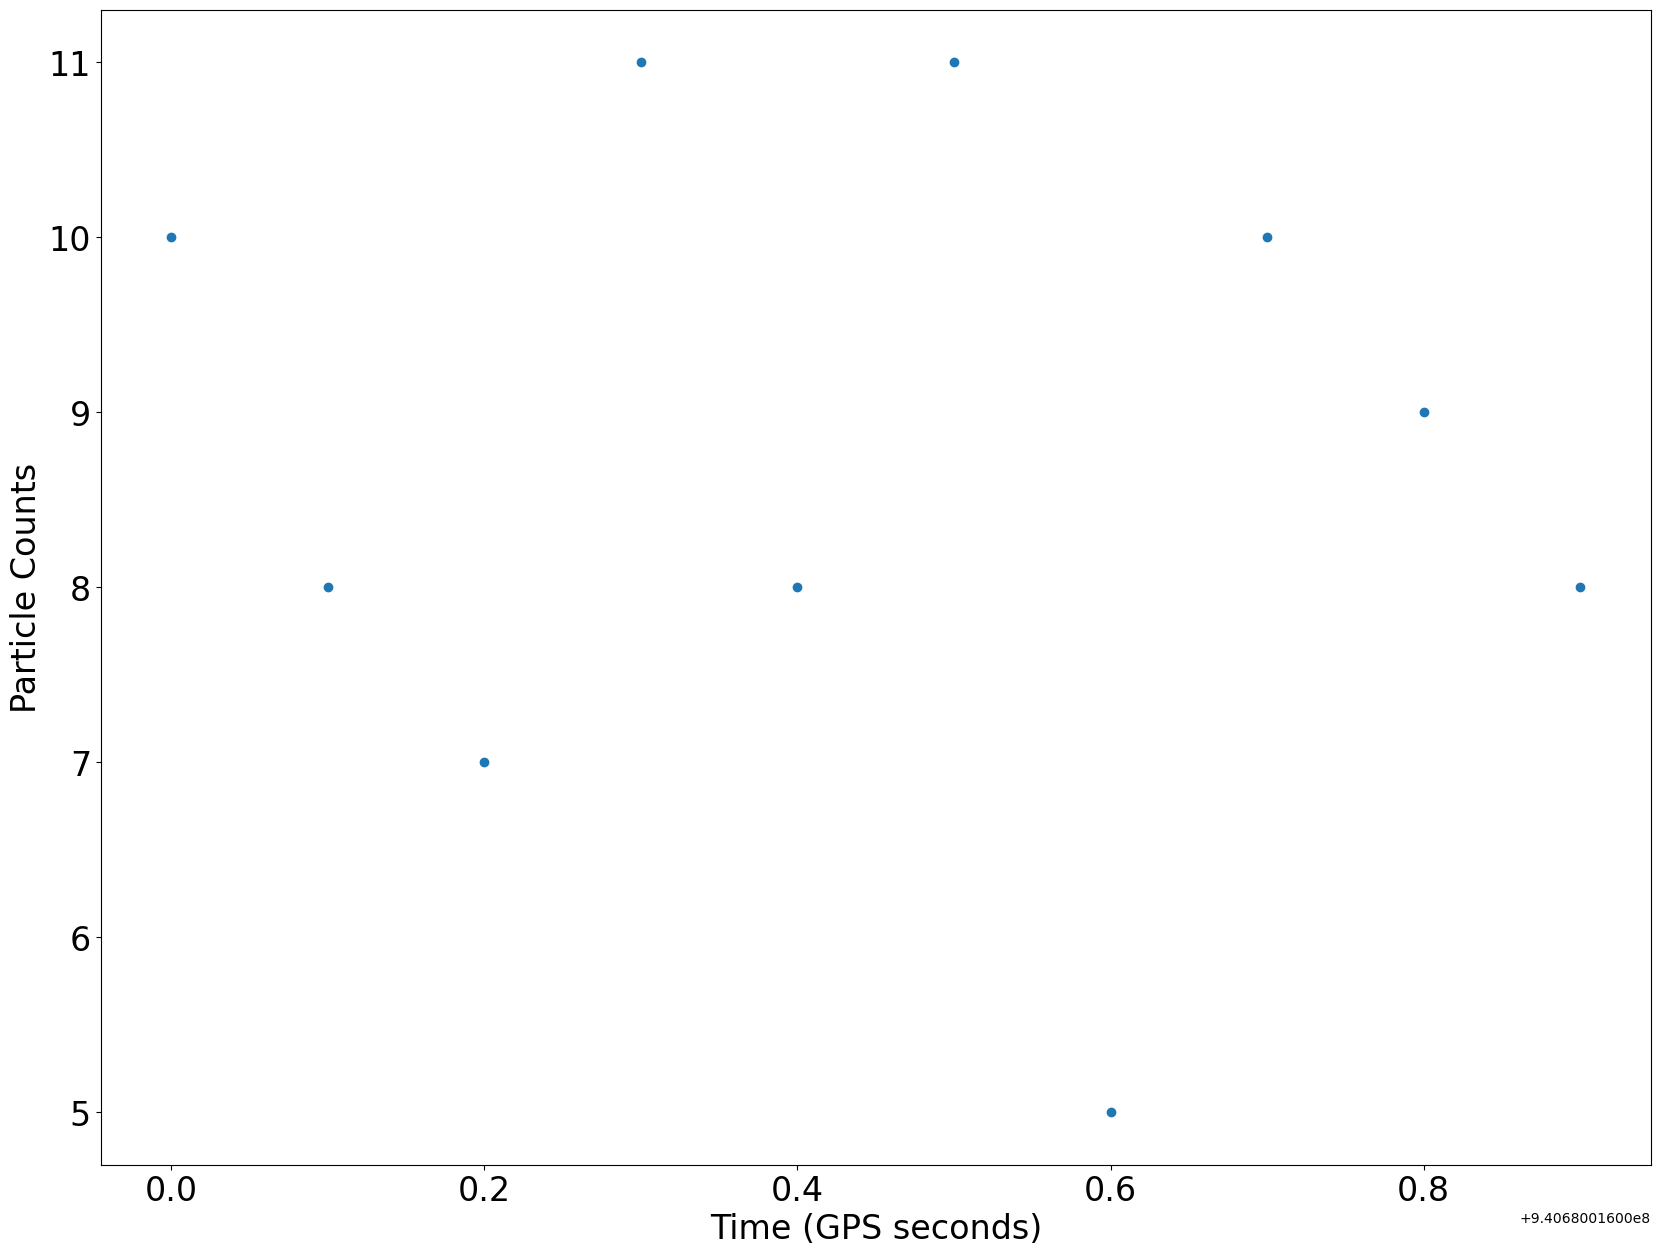

In [7]:
times_pc_1, particle_counts_1 = get_subset(times, metadata, num_particles_idx, 0, 10)

generate_scatter_plot(times_pc_1, particle_counts_1, 'Particle Counts')

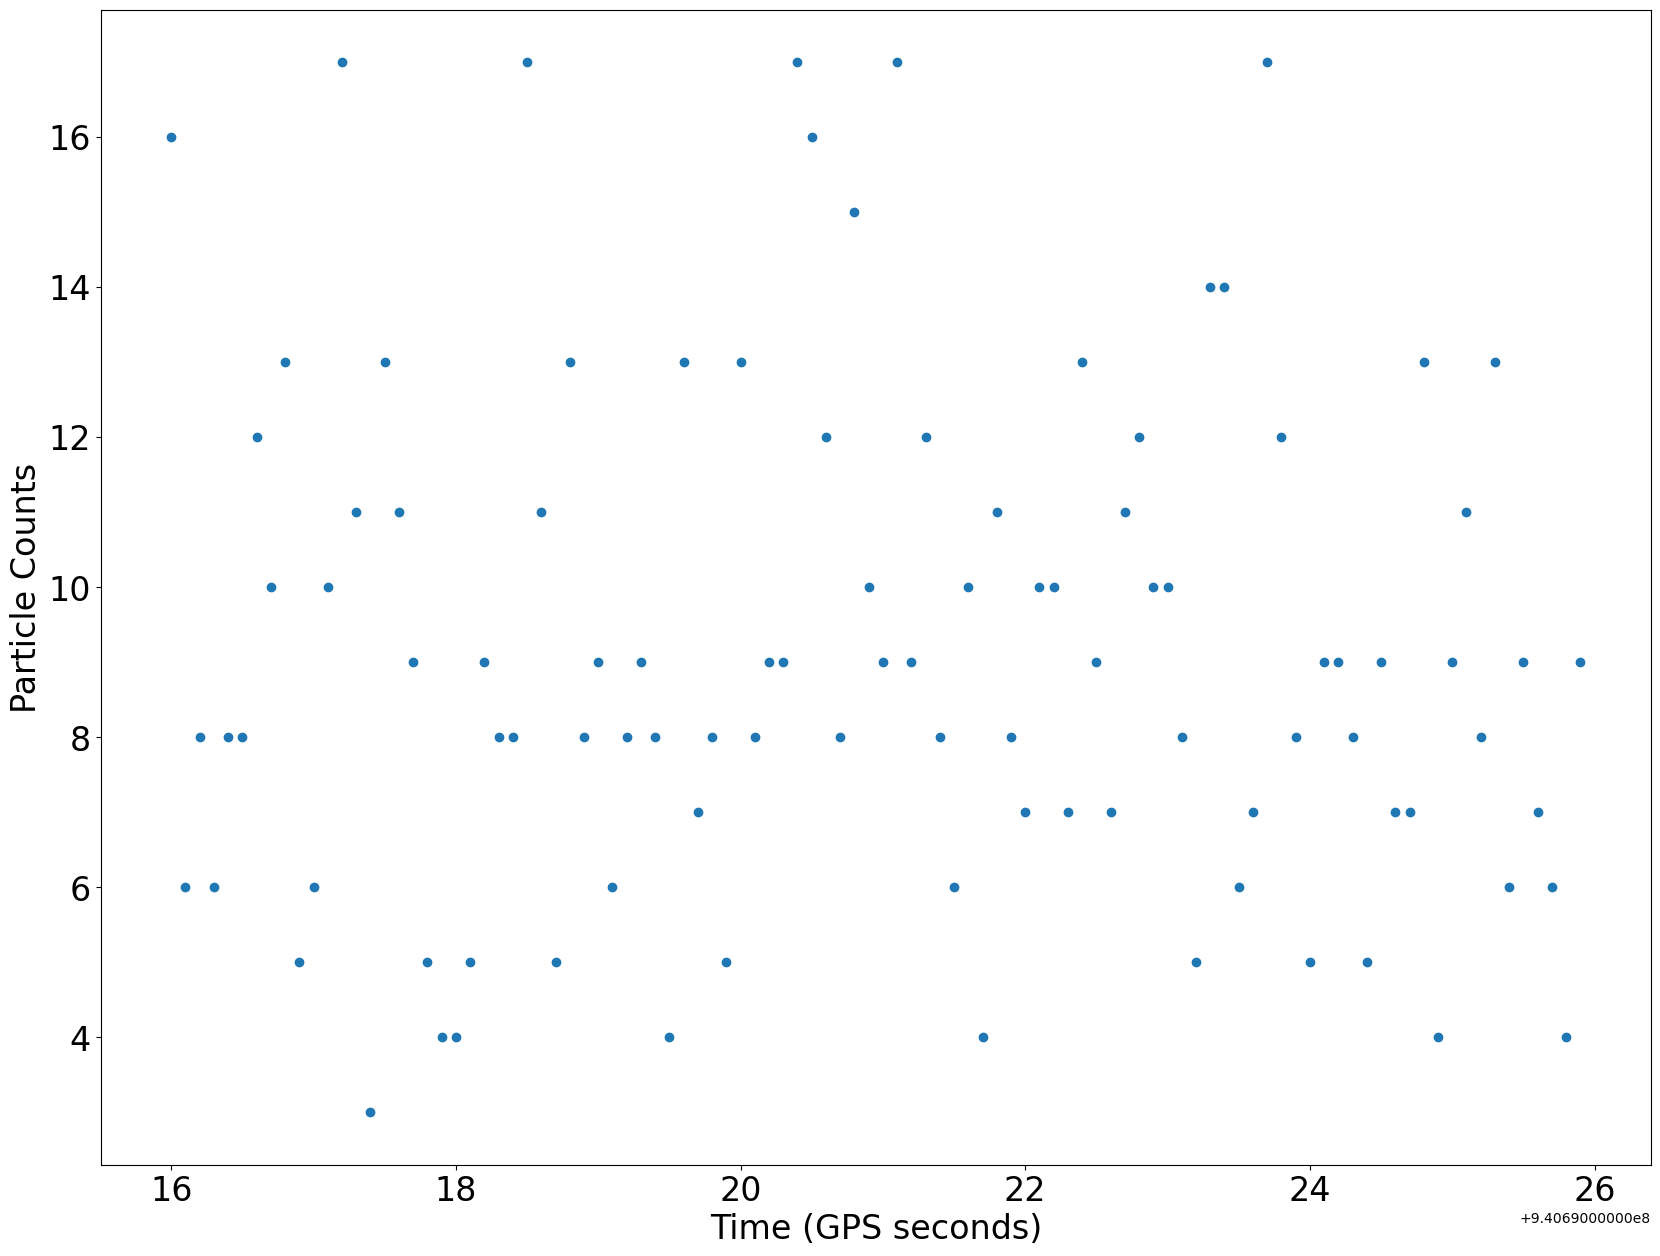

In [8]:
times_pc_2, particle_counts_2 = get_subset(times, metadata, num_particles_idx, 100000, 100)

generate_scatter_plot(times_pc_2, particle_counts_2, 'Particle Counts')

Lets look at the particle counts when we fold the time over a period of the orbit which is 90 minutes or $90*60=5400$ GPS seconds - which is equivalent to $5400*10=54000$ consecutive data points in our array - by plotting our results on a 2D histogram.  Once again we will plot the folded data over one period then again over multiple periods.

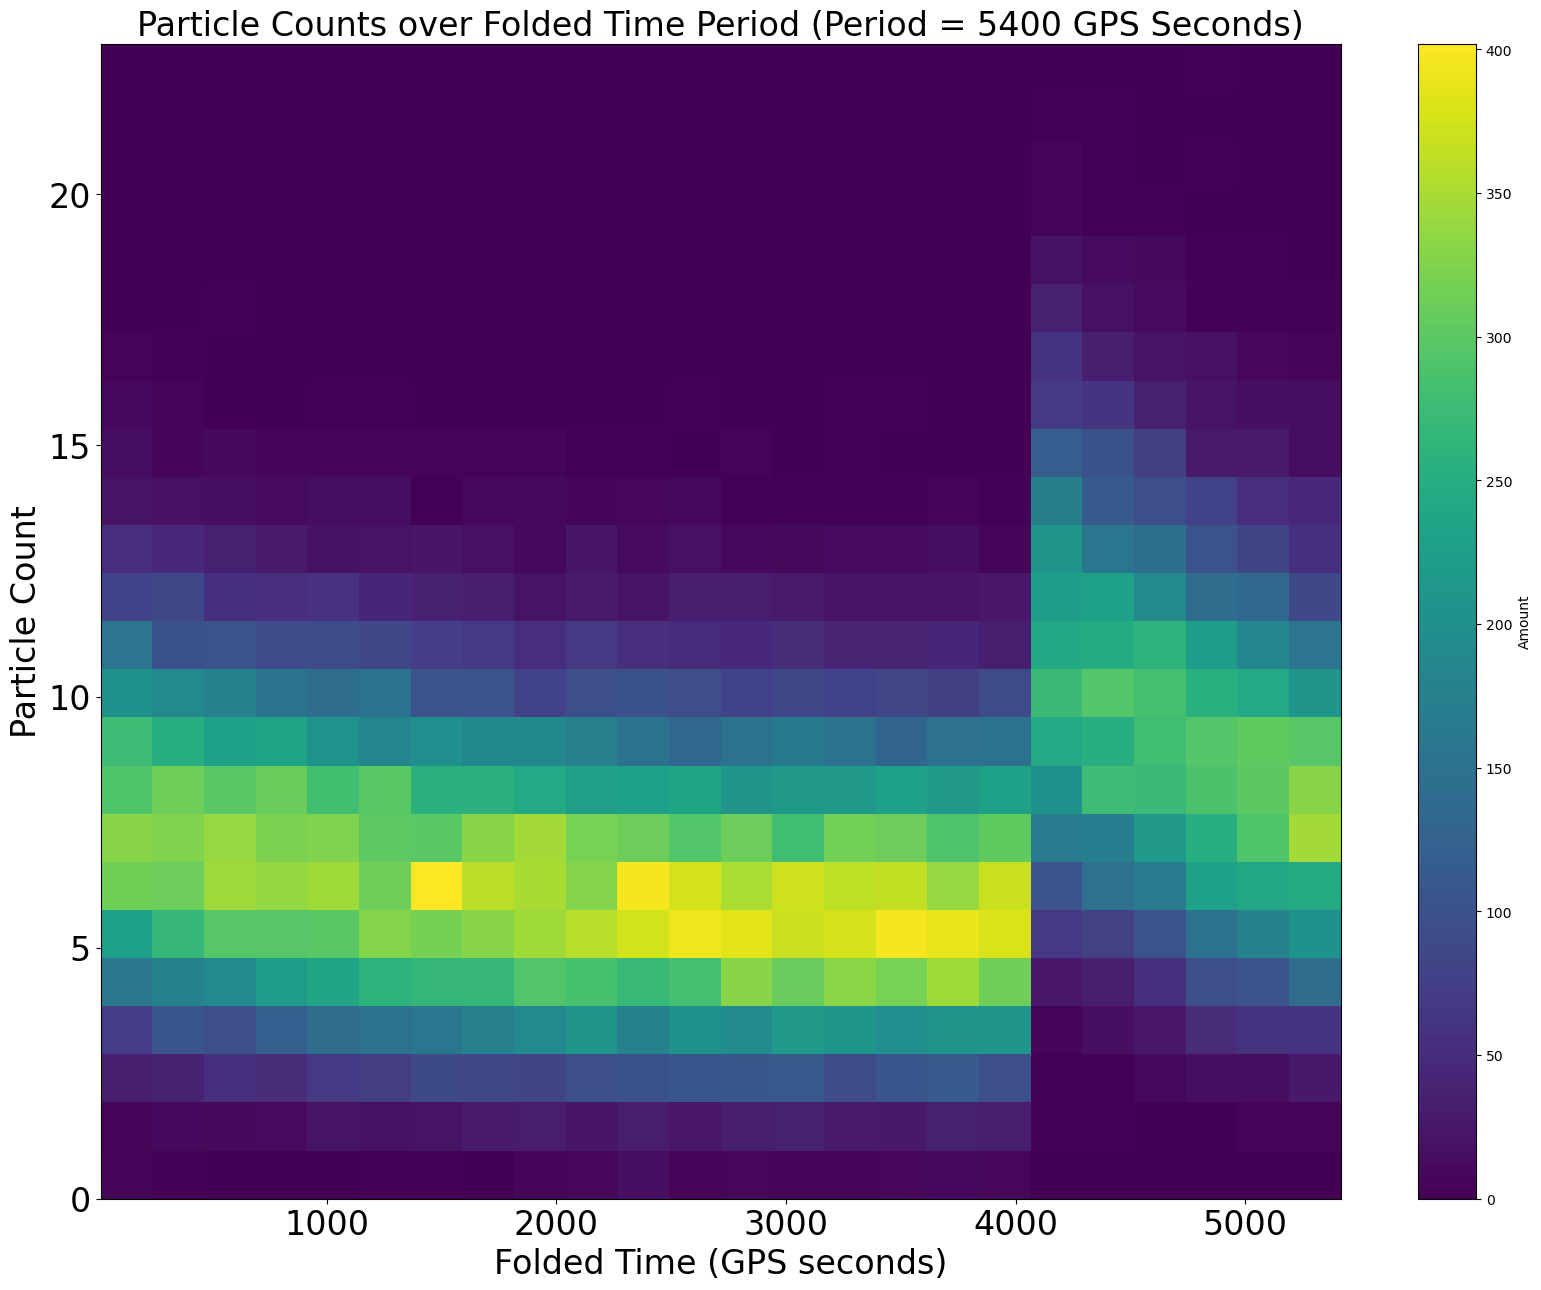

In [9]:
orbit_period = 90*60*10
times_folded = times % orbit_period

times_folded_pc_3, particle_counts_3 = get_subset(times_folded, metadata, num_particles_idx, 0, orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_folded_pc_3, particle_counts_3, bins=24)
plt.tick_params(labelsize=24)
plt.ylim(0, 23)
plt.title('Particle Counts over Folded Time Period (Period = 5400 GPS Seconds)', fontsize=24)
plt.xlabel('Folded Time (GPS seconds)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.show()

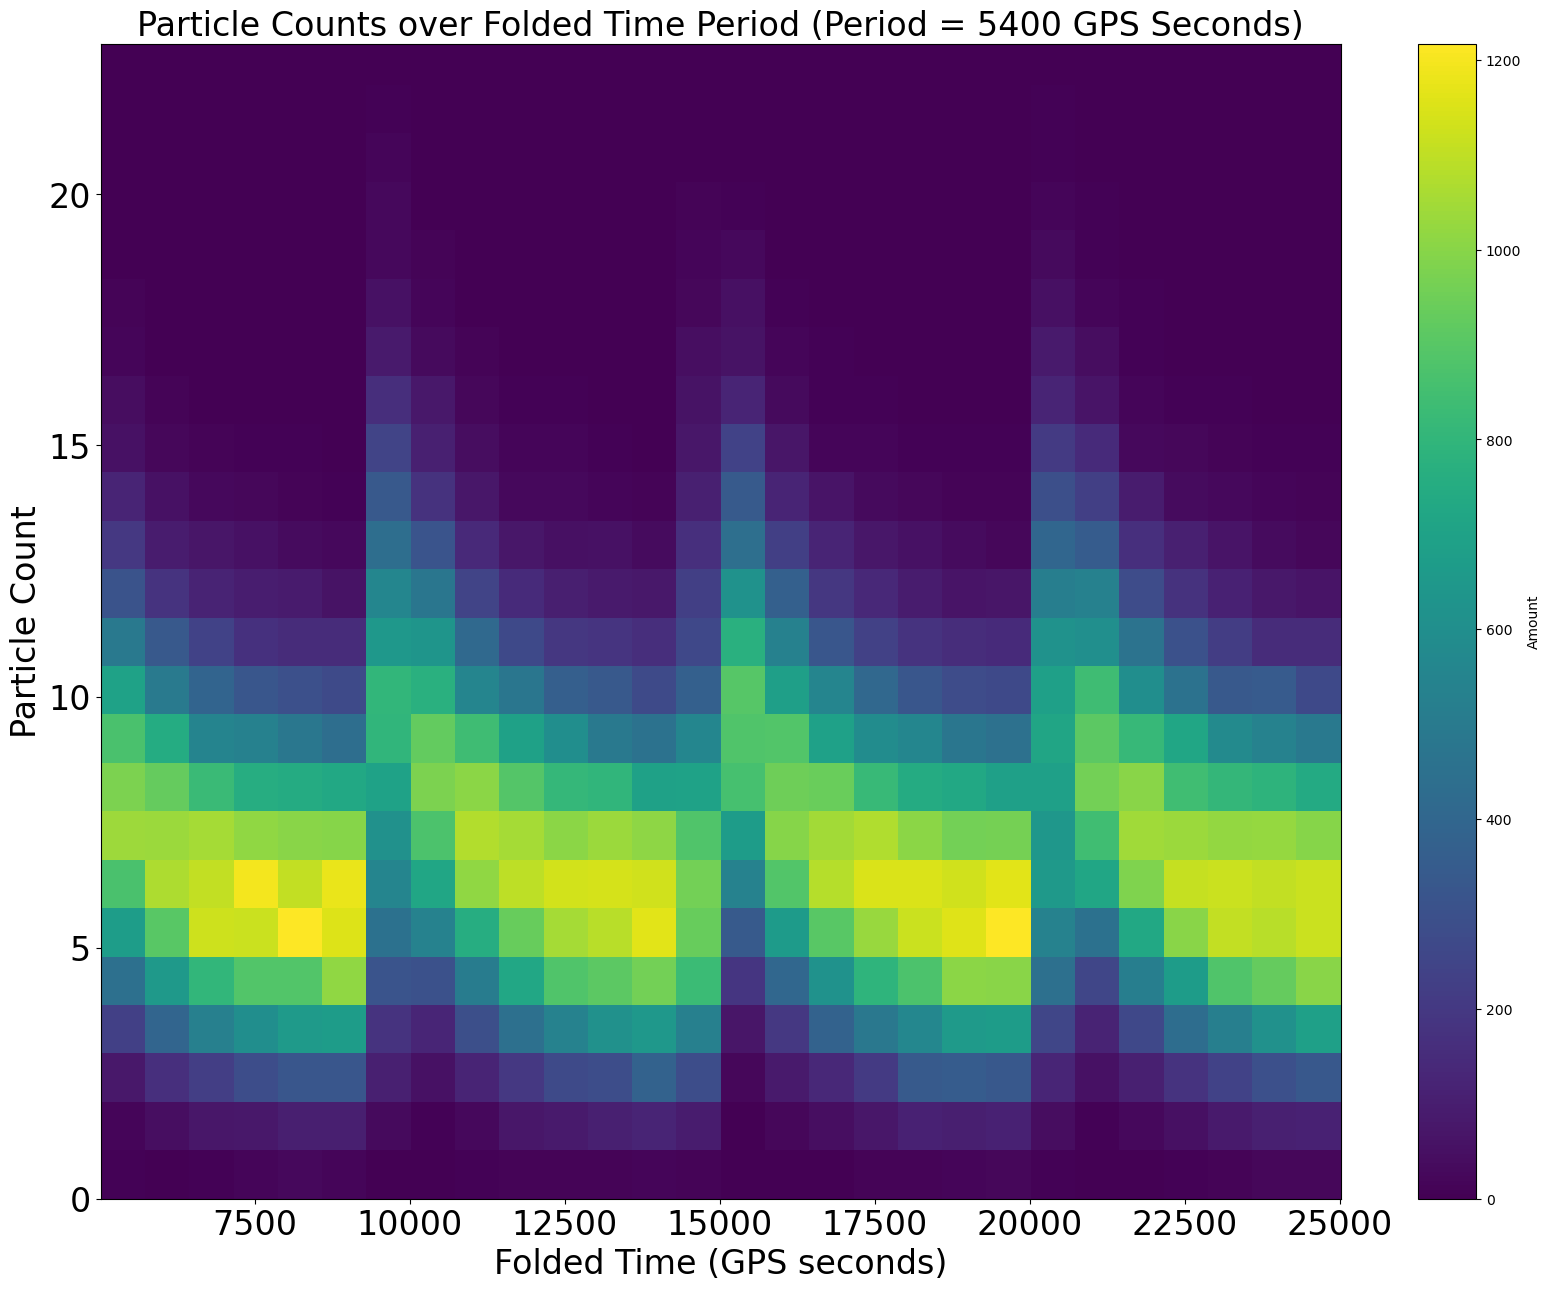

In [10]:
times_folded_pc_4, particle_counts_4 = get_subset(times_folded, metadata, num_particles_idx, 50000, 200000)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_folded_pc_4, particle_counts_4, bins=28)
plt.tick_params(labelsize=24)
plt.ylim(0, 23)
plt.title('Particle Counts over Folded Time Period (Period = 5400 GPS Seconds)', fontsize=24)
plt.xlabel('Folded Time (GPS seconds)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.show()

From the above plots we can draw many initial conclusions - let's begin with the most obvious ones.  In the first two plots we see that the Solar Phase and the Earth Longitude increase linearly with time then reset back to 0.  This reset is due to both of these values being 'cyclic', or periodic, and the linear increase is due to the satellite orbiting at - approximately - a constant speed.

Next we will observe the plots regarding the number of particles counted during each 100 millisecond GPS period.  From the first scatter plot we see that there is a fluctuation between, on average, around 11 particles at a maximum and 4 at a minimum.  Looking over a larger range of times in the second scatter plot we see that the average still lies between 11 and 4 - however most measurements are around 5 or 7.

Next in the histogram plots we see that the majority of the particles detected lie within the ranges previously defined however we now see a large spikes in the number of particles detected.  In the first histogram we only see one spike but as we move to plot the data over more periods we see that the spike occurs regularly throughout the orbital cycle.  This spike appears to be signal contamination.

To explore this 'spike' further we moved to plot more data over the orbital period and we found that the spike was not eliminated however we do see that as we consider more data a mean reading of around 6 or 7 particles being detected during a GPS second emerges. 

Let's explore this spike further by determining at what point we have the first full solar phase cycle and when we have the first full earth longitudinal cycle.  Once we know these values we will visualize the particle counts during the cycle.

In [11]:
# determine when the first solar phase cycle begins
first_solar_cycle_begin = -1
for i in range(0, len(metadata[solar_phase_idx])):
    if metadata[solar_phase_idx,i] <= 10:
        first_solar_cycle_begin = i
        break
        
# determine when the first earth longitude cycle begins
first_earth_long_begin = -1
for i in range(0, len(metadata[earth_long_idx])):
    if metadata[earth_long_idx,i] <= 10:
        first_earth_long_begin = i
        break

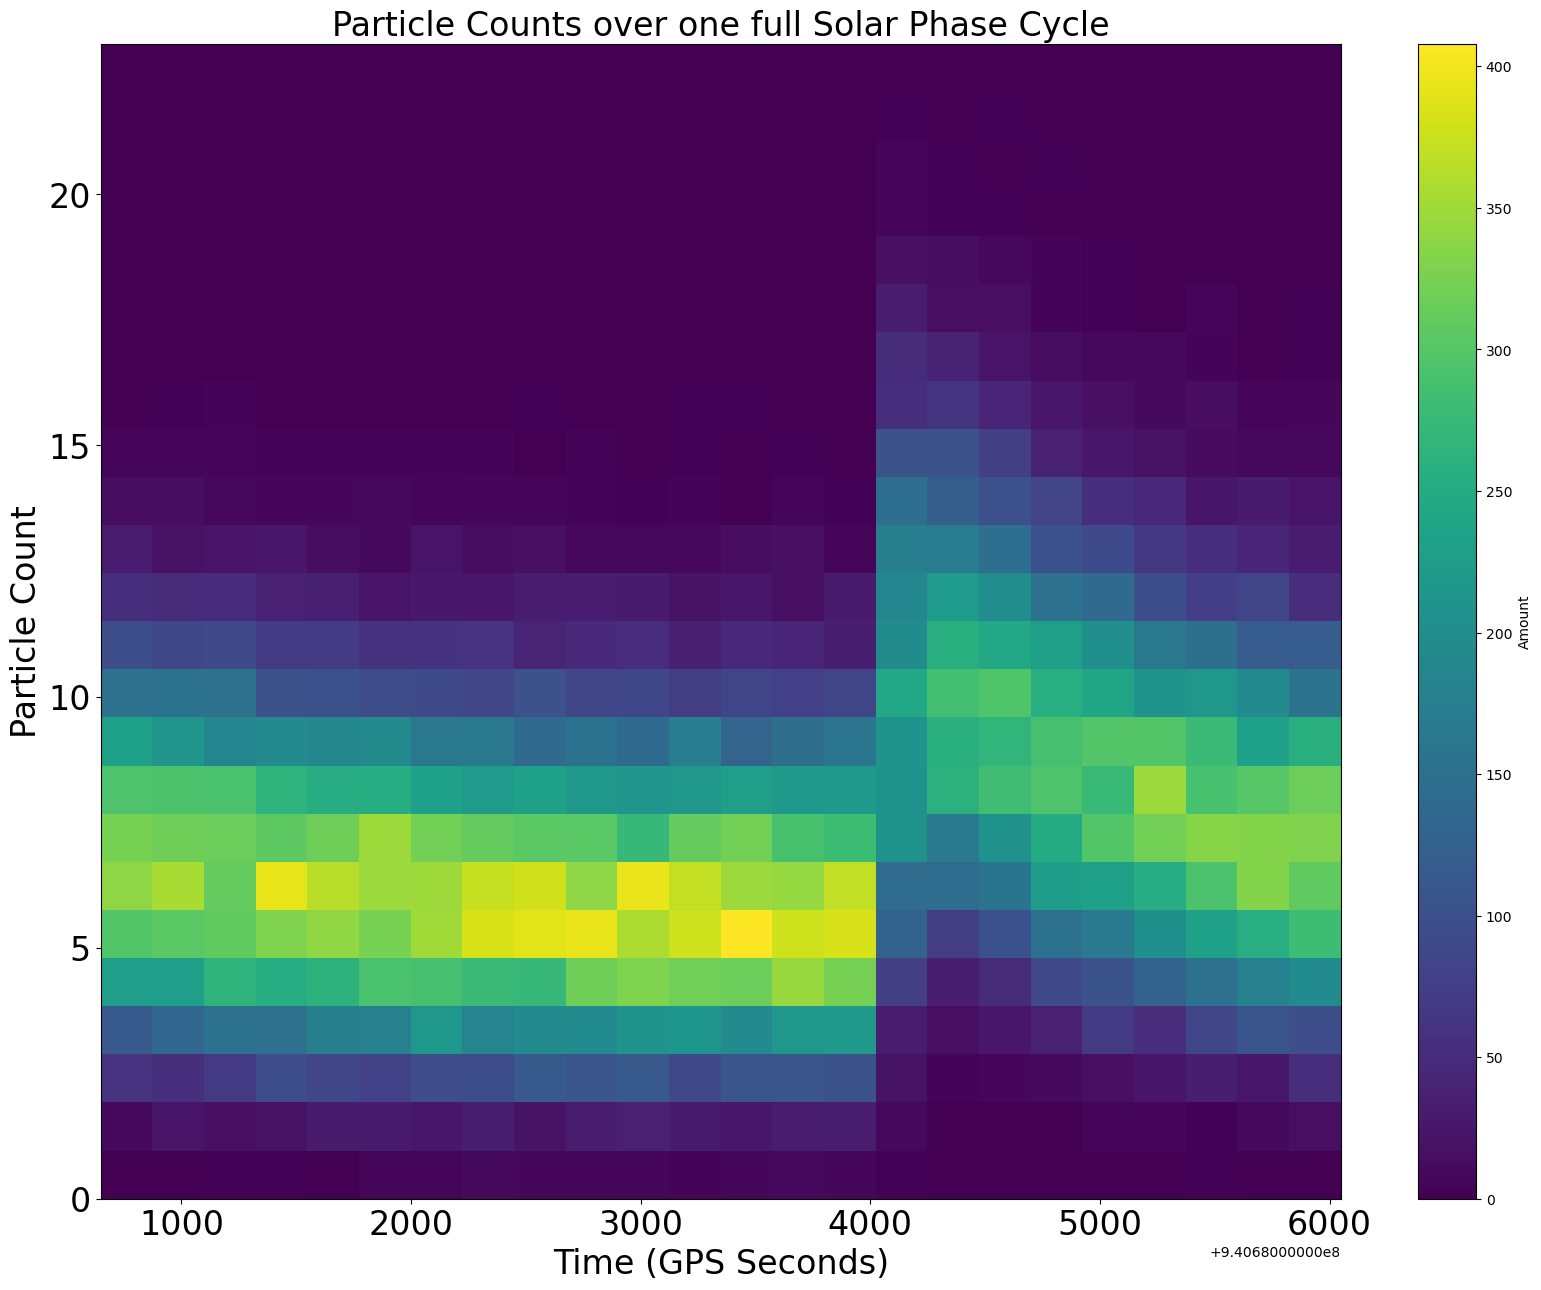

In [12]:
times_sp_cycle_1, num_particles_sp_cycle_1 = get_subset(times, metadata, num_particles_idx, first_solar_cycle_begin, orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_sp_cycle_1, num_particles_sp_cycle_1, bins=24)
plt.tick_params(labelsize=24)
plt.title('Particle Counts over one full Solar Phase Cycle', fontsize=24)
plt.xlabel('Time (GPS Seconds)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.show()

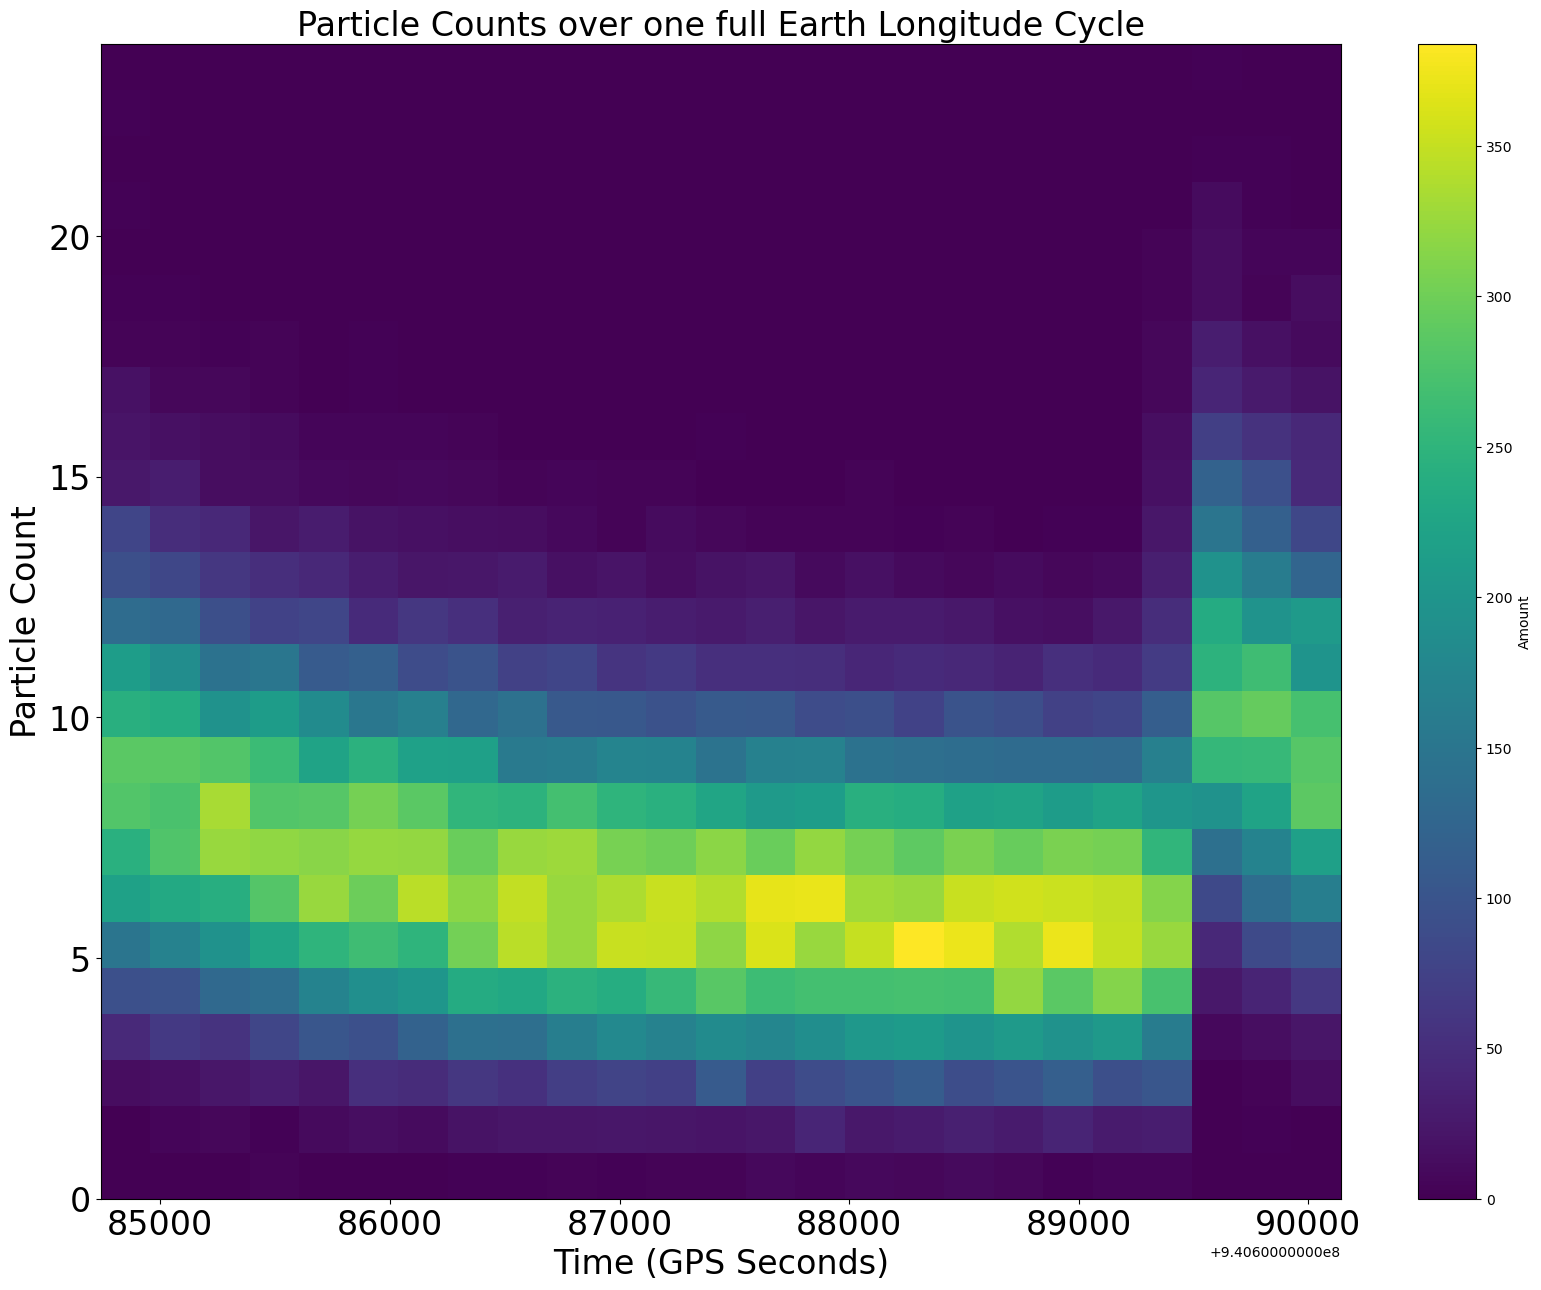

In [13]:
times_el_cycle_1, num_particles_el_cycle_1 = get_subset(times, metadata, num_particles_idx, first_earth_long_begin, orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_el_cycle_1, num_particles_el_cycle_1, bins=25)
plt.tick_params(labelsize=24)
plt.title('Particle Counts over one full Earth Longitude Cycle', fontsize=24)
plt.xlabel('Time (GPS Seconds)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.show()

From the above plots we can draw a few more conclusions.  First of all we see that the spike in the number of particles detected happens once every cycle.  Further more it occurs at a very specific point during the solar cycle and during the earth longitudinal cycle.  Recall that both of these values are in units of degrees thus they vary linearly from 0 to 360 degrees throughout the cycle.  Visually from the above graph we can see the 16th bin (out of 24) is when the spike occurs thus on a linear scale this occurs at a solar phase of about $360 * \frac{16}{24} = 240$ degrees.  Similarly for the plot on the earth longitude cycle we see the spike in bin 23 out of 25 bins thus we see the spike at a value of around $360 * \frac{23}{25} = 331.2$ degrees.


Lets look over more than just one cycle after offsetting forward into the array by some amount of cycles from the initial cycle beginning point:

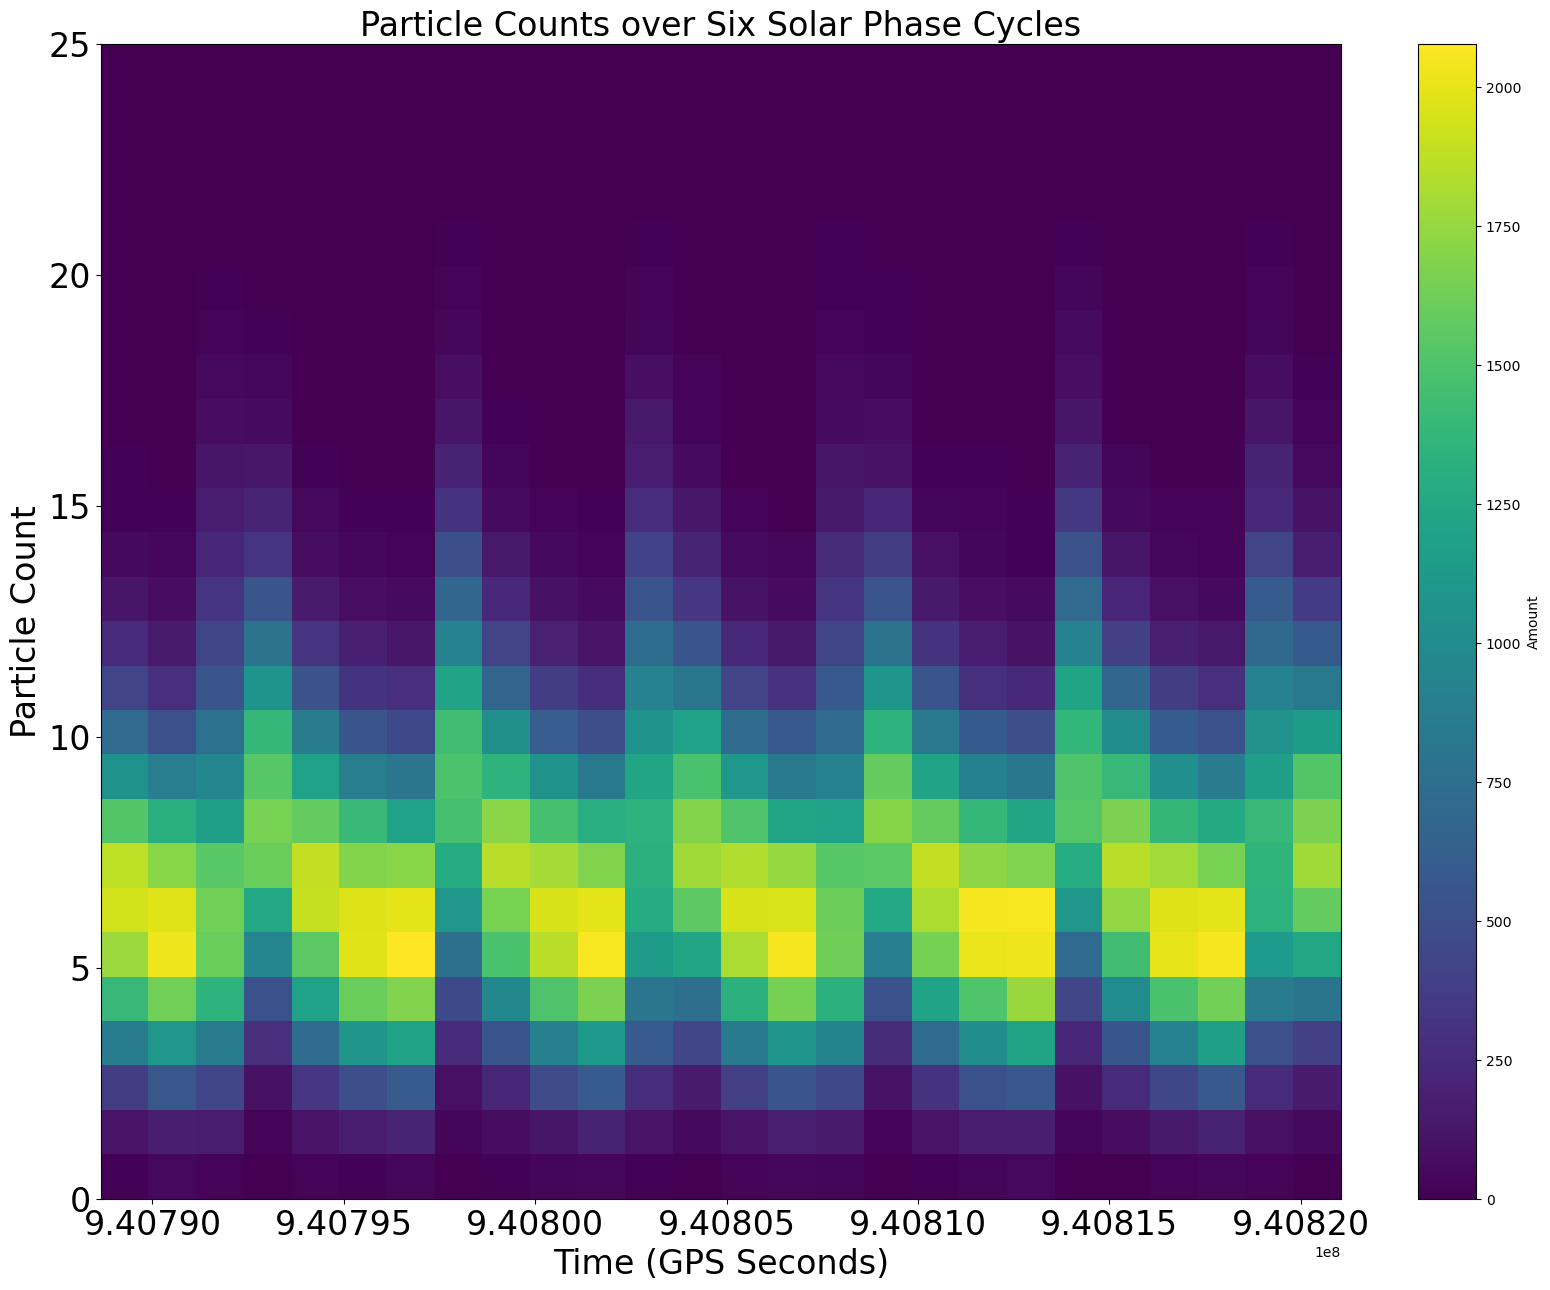

In [14]:
times_sp_cycle_2, num_particles_sp_cycle_2 = get_subset(times, metadata, num_particles_idx, first_solar_cycle_begin + (20*orbit_period), 6*orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_sp_cycle_2, num_particles_sp_cycle_2, bins=26)
plt.tick_params(labelsize=24)
plt.title('Particle Counts over Six Solar Phase Cycles', fontsize=24)
plt.xlabel('Time (GPS Seconds)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.show()

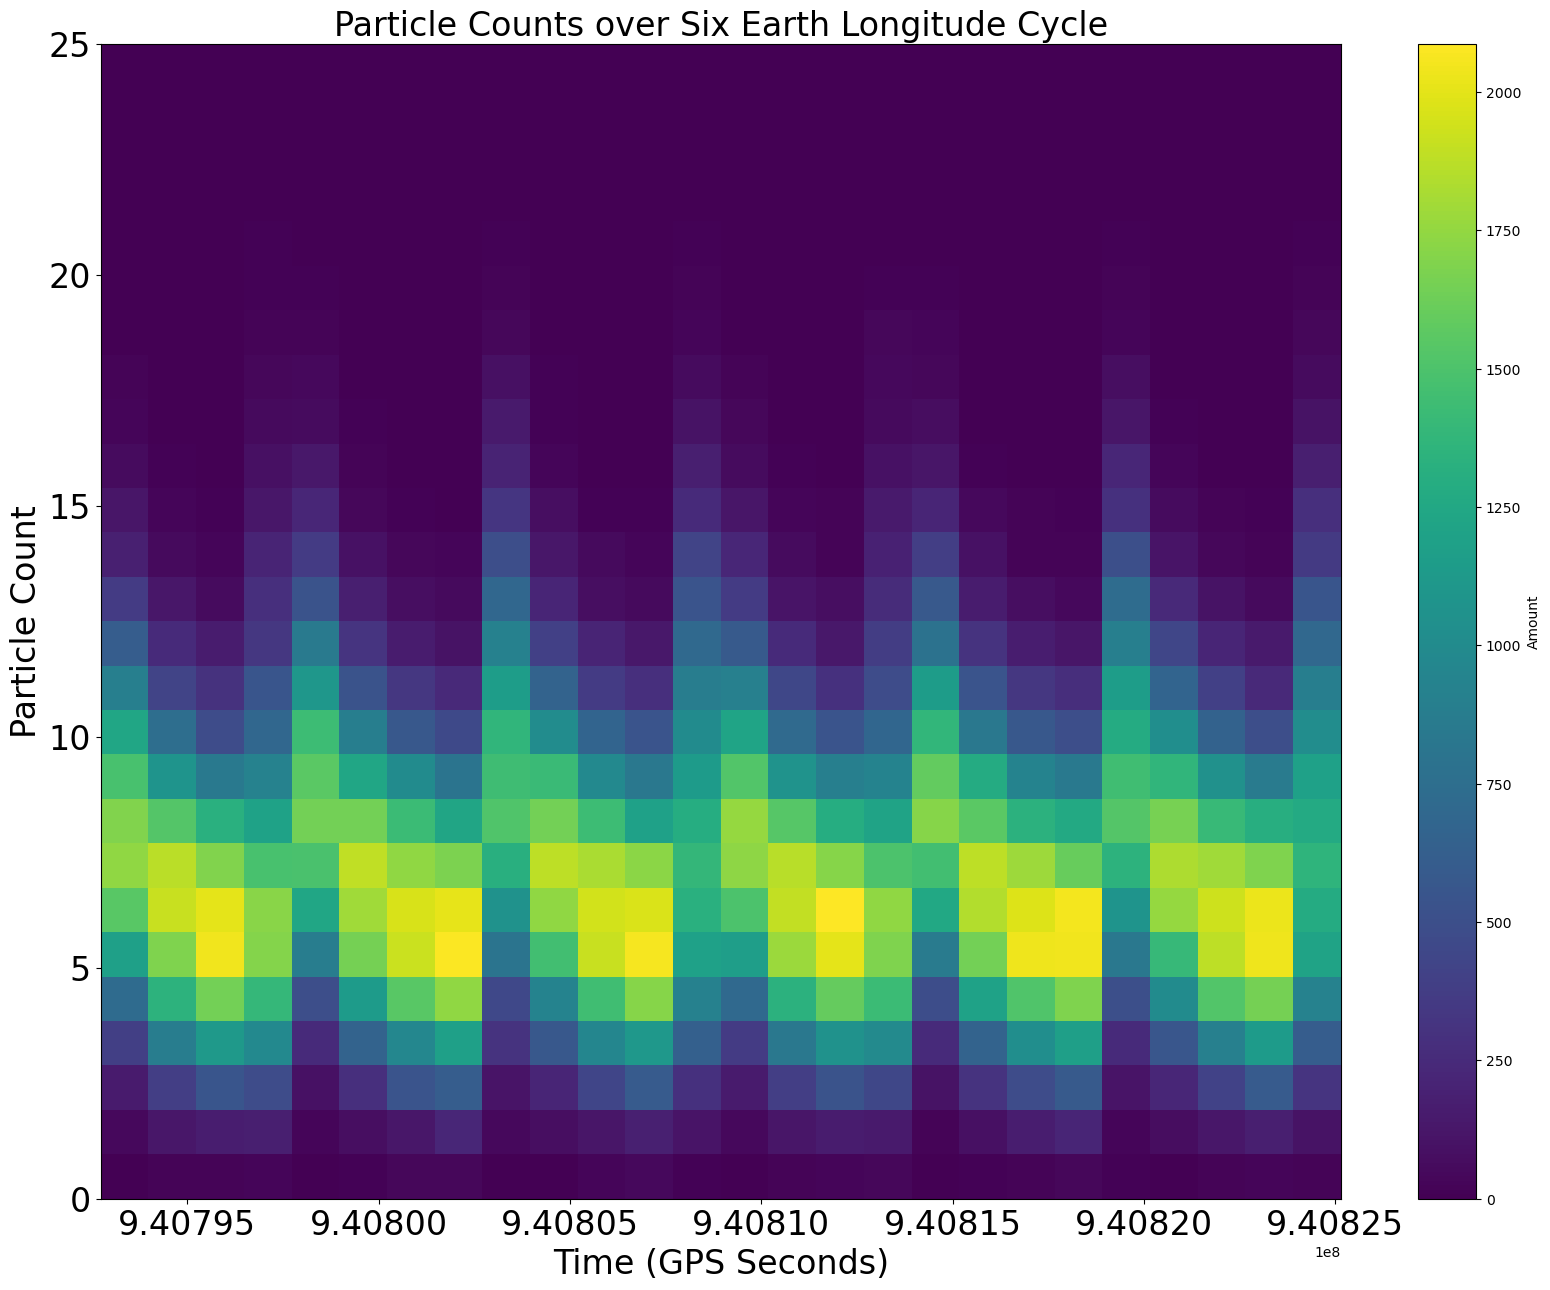

In [15]:
times_el_cycle_2, num_particles_el_cycle_2 = get_subset(times, metadata, num_particles_idx, first_earth_long_begin + (20*orbit_period), 6*orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_el_cycle_2, num_particles_el_cycle_2, bins=26)
plt.tick_params(labelsize=24)
plt.title('Particle Counts over Six Earth Longitude Cycle', fontsize=24)
plt.xlabel('Time (GPS Seconds)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.show()

From the two previous plots we see that we do indeed have a spike every full cycle.  This can be classified as signal contamination in our data as clearly some outside source is causing our data to have an irregular reading at a regular interval throughout the orbital period.  This contamination could be due to a stark temperature change within the satellite  when it leaves the shadow of the Earth and moves back into sight of the Sun.  Let's also recap previous features noticed to collect our thoughts into one place: we saw that point where the spike occurs is at approximately 240 degrees in the Solar Period and approximately 331.2 degrees Earth Longitude.  We also found a mean value of about 6 or 7 particles being detected per 100ms on the non-spike regions of our data.  We found that the particle counts fluctuate between a minimum of around 3 and a maximum of around 10 expect when we see an irregular spike.  Finally we found that the Solar Phase and Earth Longitude increase linearly then reset back to 0 to begin their increase to 360 again as they are periodic properties.

From all of this information we can now begin to decide how we would like to construct a background pdf to model our data.  First, because we are looking at particle counts we know that we will want to choose a discrete distribution and we also know that the two most common discrete distributions are the Poisson and Binomial.  The Binomial does not make much sense here because we do not have an item that has a probability of success or probability of failure - rather we are interested in the number of events over a time interval.  This is exactly what the Poisson distribution is focused at modeling.  We also know that the cosmic background distribution is Poisson so the conclusion that Poisson would be a strong candidate for our PDF here is not surprising.  Another thing that we would like our Poisson to capture is that the most common values should be 6 or 7 particles detected, followed closely by 5 or 8 particles detected.  This distribution is for the general case.  Provided the spikes our background will follow a different distribution - suggestively a Poisson with the most common value being around 8 particles detected with 7 or 9 detections having the next highest occurrence probabilities.  Now that we have these two distributions for the spike and non-spike behavior we will want to do some sort of time averaging or fitting to determine how the distribution may evolve in time.

### Part 2

From above we see that the background distribution is **not** constant across the entirety of the dataset.  Rather the distribution is changing throughout time based on which point we are at during the orbit.  As we discussed previously, because we are counting something we need to use a discrete distribution.  Also we will be using a Poisson distribution because that is the general PDF used when counting cosmic rays.  Now the Poisson distribution only has one parameter that we can change which is $\lambda$.  As our distribution is changing in time we will need our parameter $\lambda$ to be time dependent.  Looking at the plot above it looks like the mean mean value for the number of particles detected has some negative exponential dependance if we define the beginning of a cycle to be right after a spike occurs.  As the parameter $\lambda$ is capturing this mean value, we will look for an exponential decay function to model the parameter $\lambda$.  In the next step we will determine a precise PDF for the changing background distribution.


### Part 3

Lets explore constructing a Poisson distribution that has a parameter $\lambda$ that varies in time - specifically varying with respect to an exponential function.  Above we have a plot of the number of particles detected over a full earth longitude cycle, let's begin with this plot to determine our exact distribution.  This plot is repeated below:

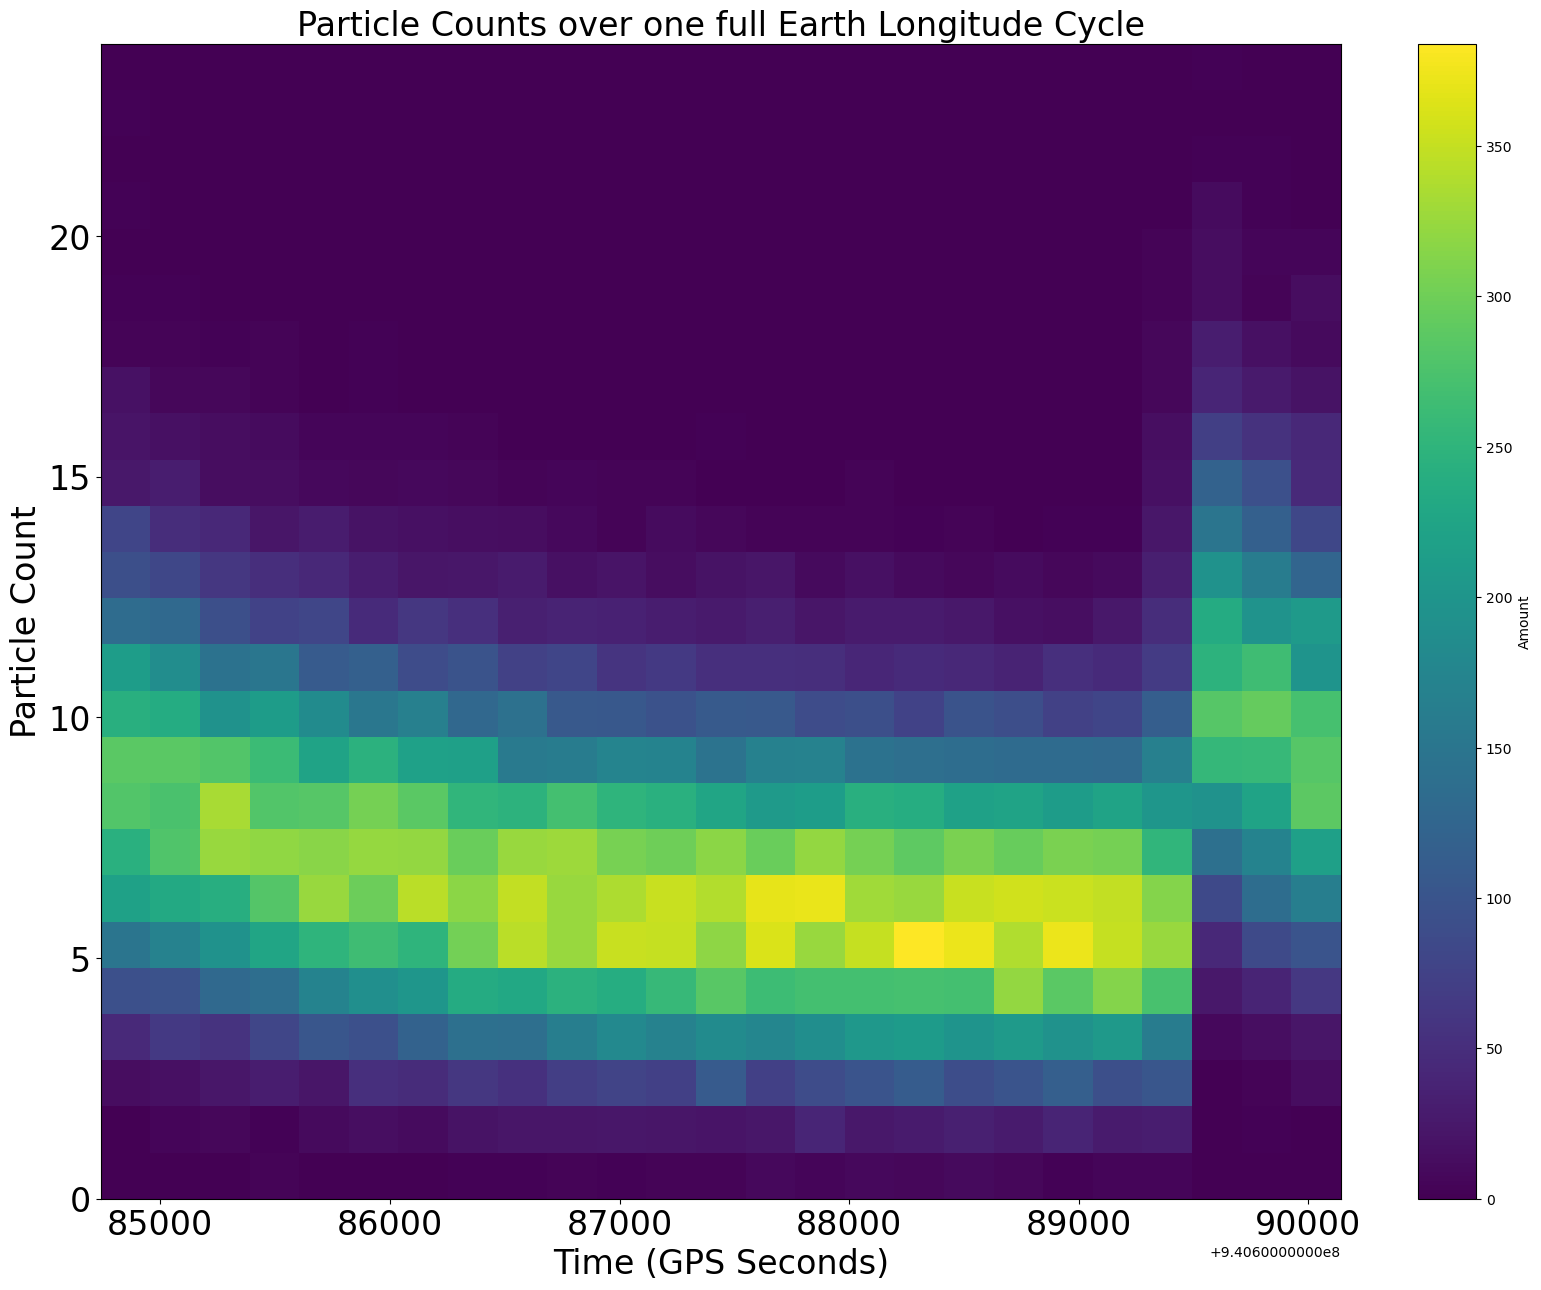

In [16]:
fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_el_cycle_1, num_particles_el_cycle_1, bins=25)
plt.tick_params(labelsize=24)
plt.title('Particle Counts over one full Earth Longitude Cycle', fontsize=24)
plt.xlabel('Time (GPS Seconds)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.show()

To determine a more precise time dependance for the parameter $\lambda$ lets observe the the particle counts with respect to the earth longitude over a large number of data points.  Naturally, this data will be folded as the earth longitude is a periodic parameter:

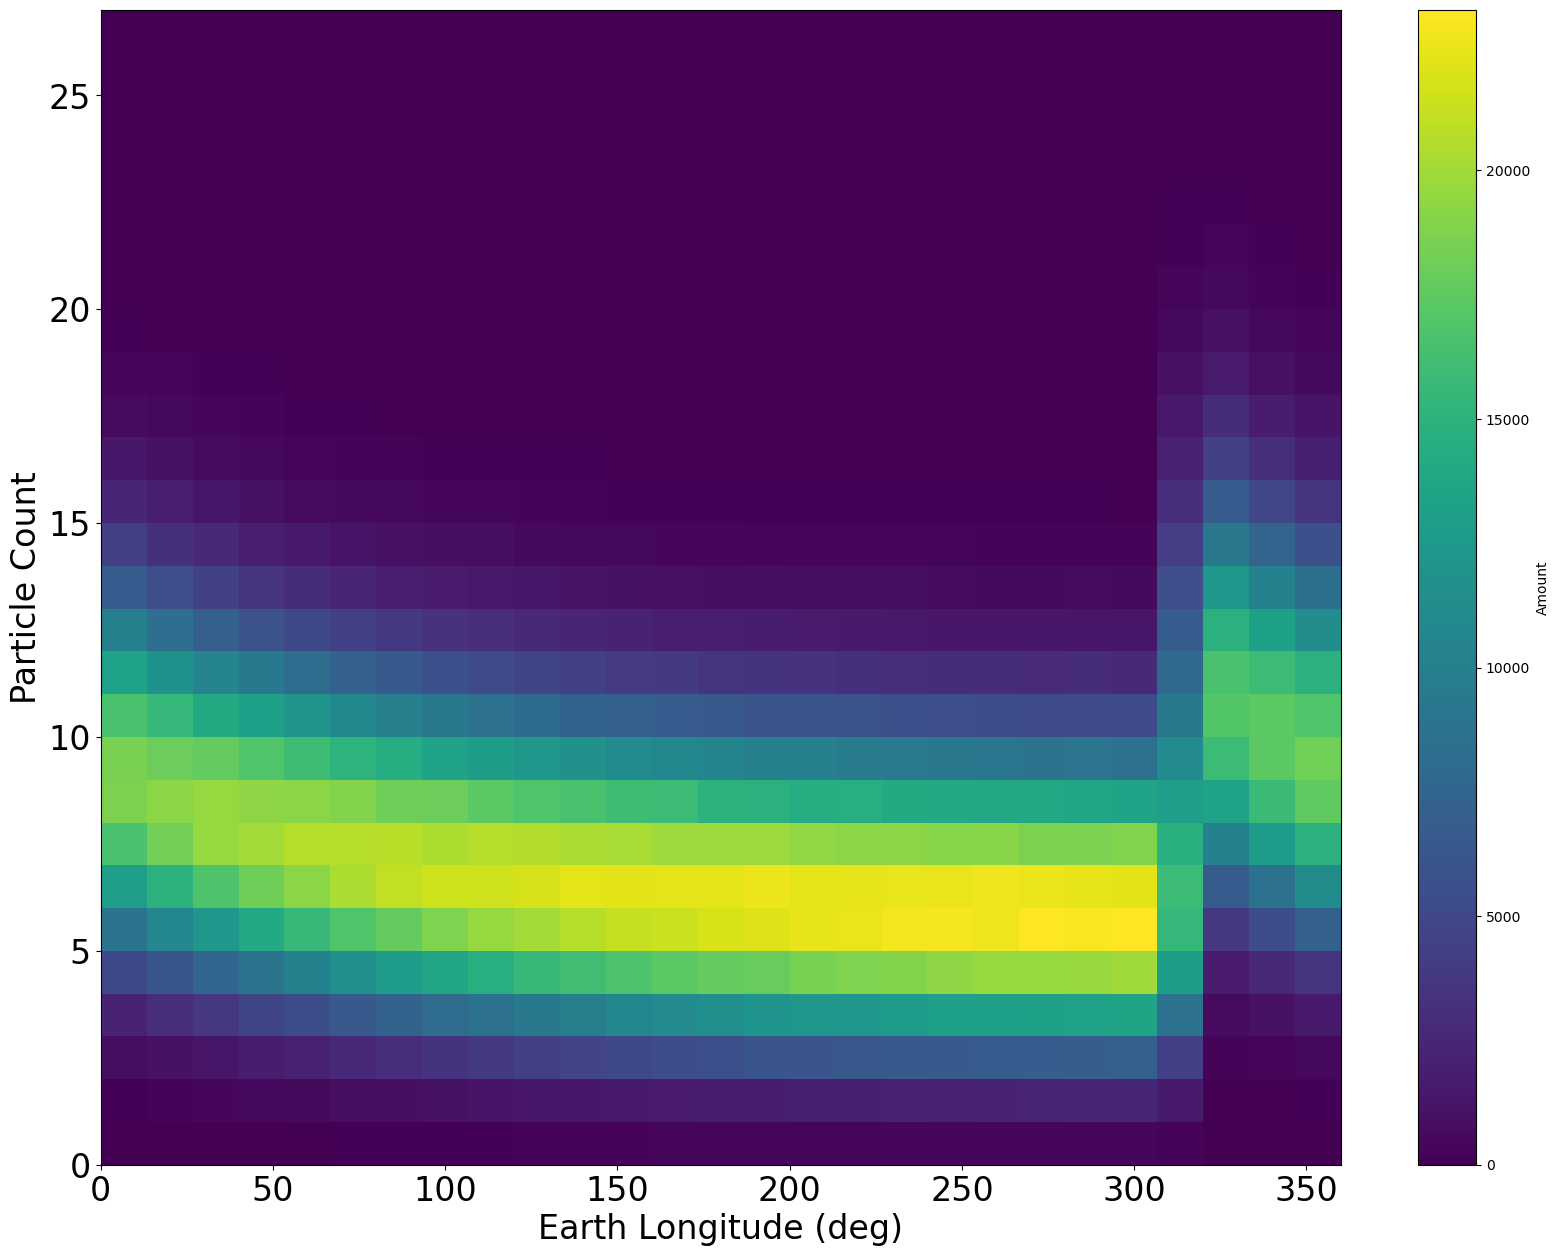

In [17]:
earth_long_cycle_2, num_particles_el_cycle_2 = get_subset(metadata[earth_long_idx,:], metadata, num_particles_idx, 0, 70*orbit_period)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(earth_long_cycle_2, num_particles_el_cycle_2, bins=27)
plt.tick_params(labelsize=24)
plt.xlabel('Earth Longitude (deg)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.show()

We see that the cycle begins to repeat when the earth longitude is equal to around $325$ degrees.  Tinkering with this exact value we find that the cycle truly repeats when the earth longitude is equal to $314$ degrees.  Let's plot the phase shifted graph:

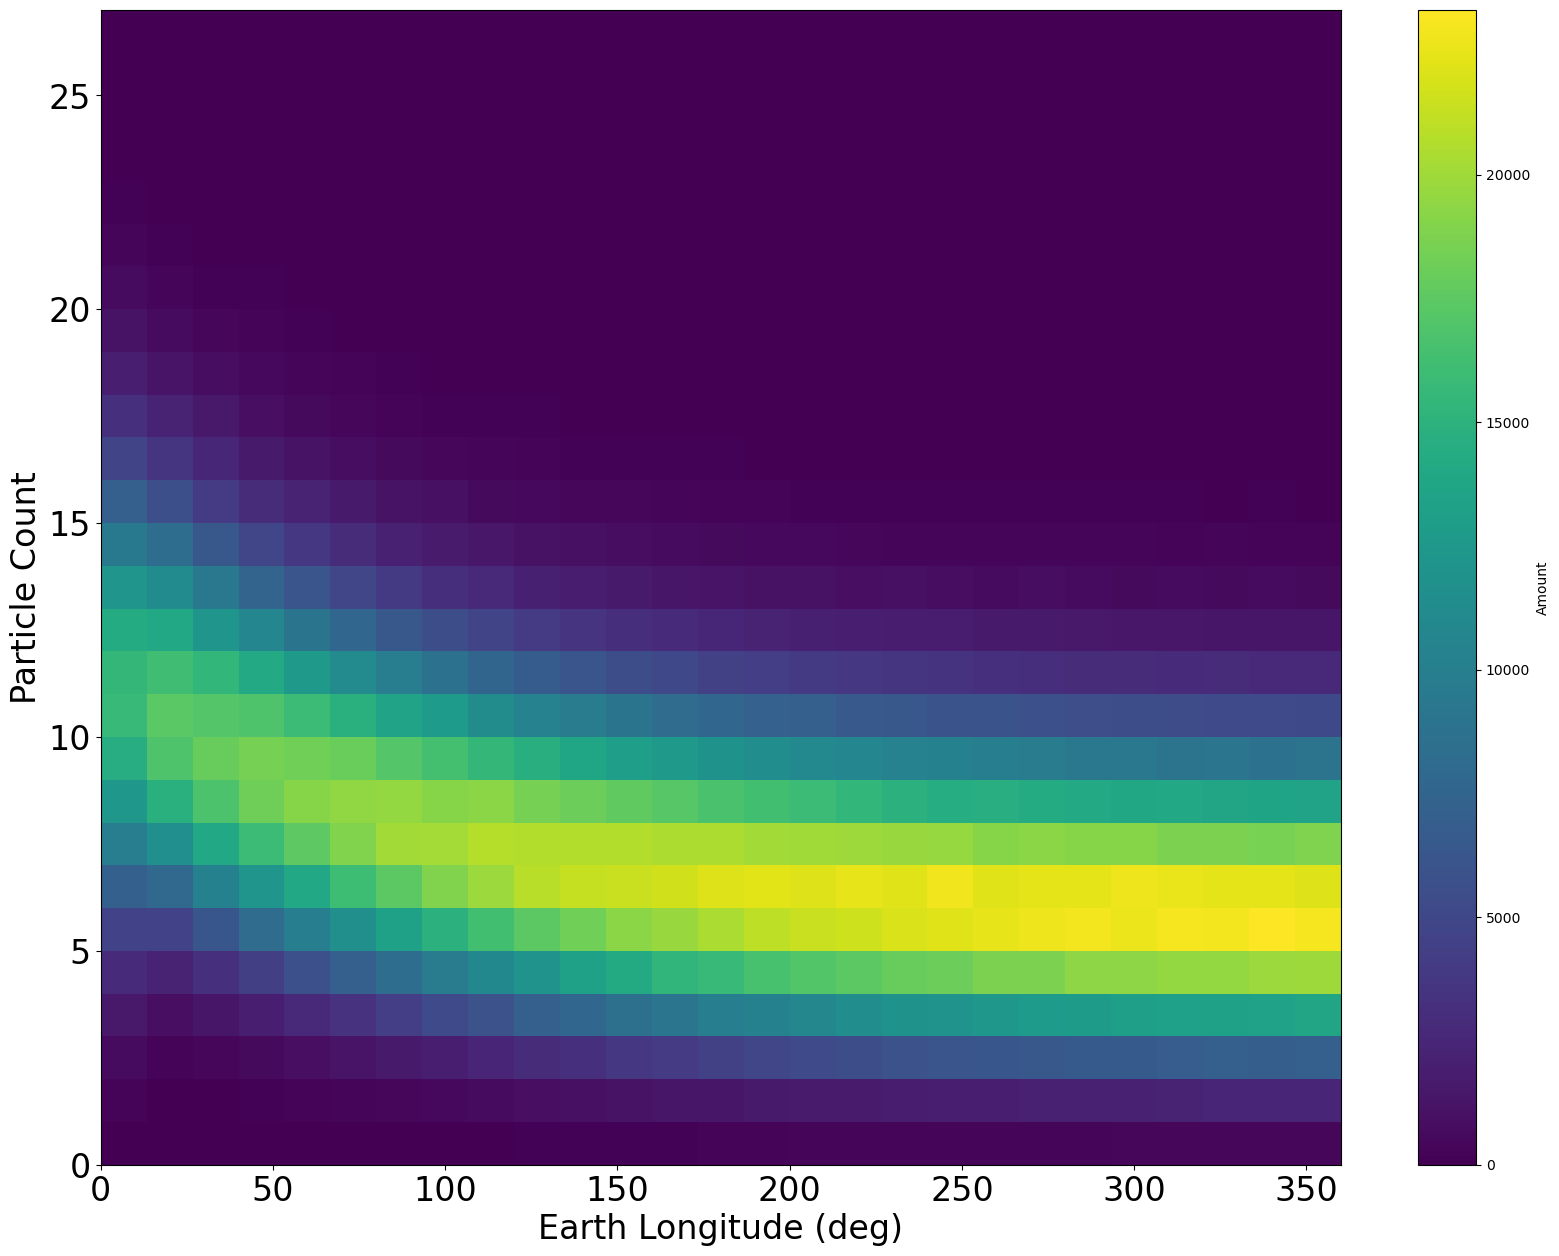

In [18]:
earth_long_cycle_repeat = 314

earth_long_cycle_3, num_particles_el_cycle_3 = get_subset(metadata[earth_long_idx,:], metadata, num_particles_idx, 0, 70*orbit_period)

earth_long_cycle_3 = (earth_long_cycle_3 - earth_long_cycle_repeat) % 360

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(earth_long_cycle_3, num_particles_el_cycle_3, bins=27)
plt.tick_params(labelsize=24)
plt.xlabel('Earth Longitude (deg)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.show()

With this plot lets now tinker and fit an exponential function to our data.  Once we find this exponential function this function will be exactly our parameter of $\lambda$ in terms of the earth longitude - then we will convert to make $\lambda$ a function of time. 

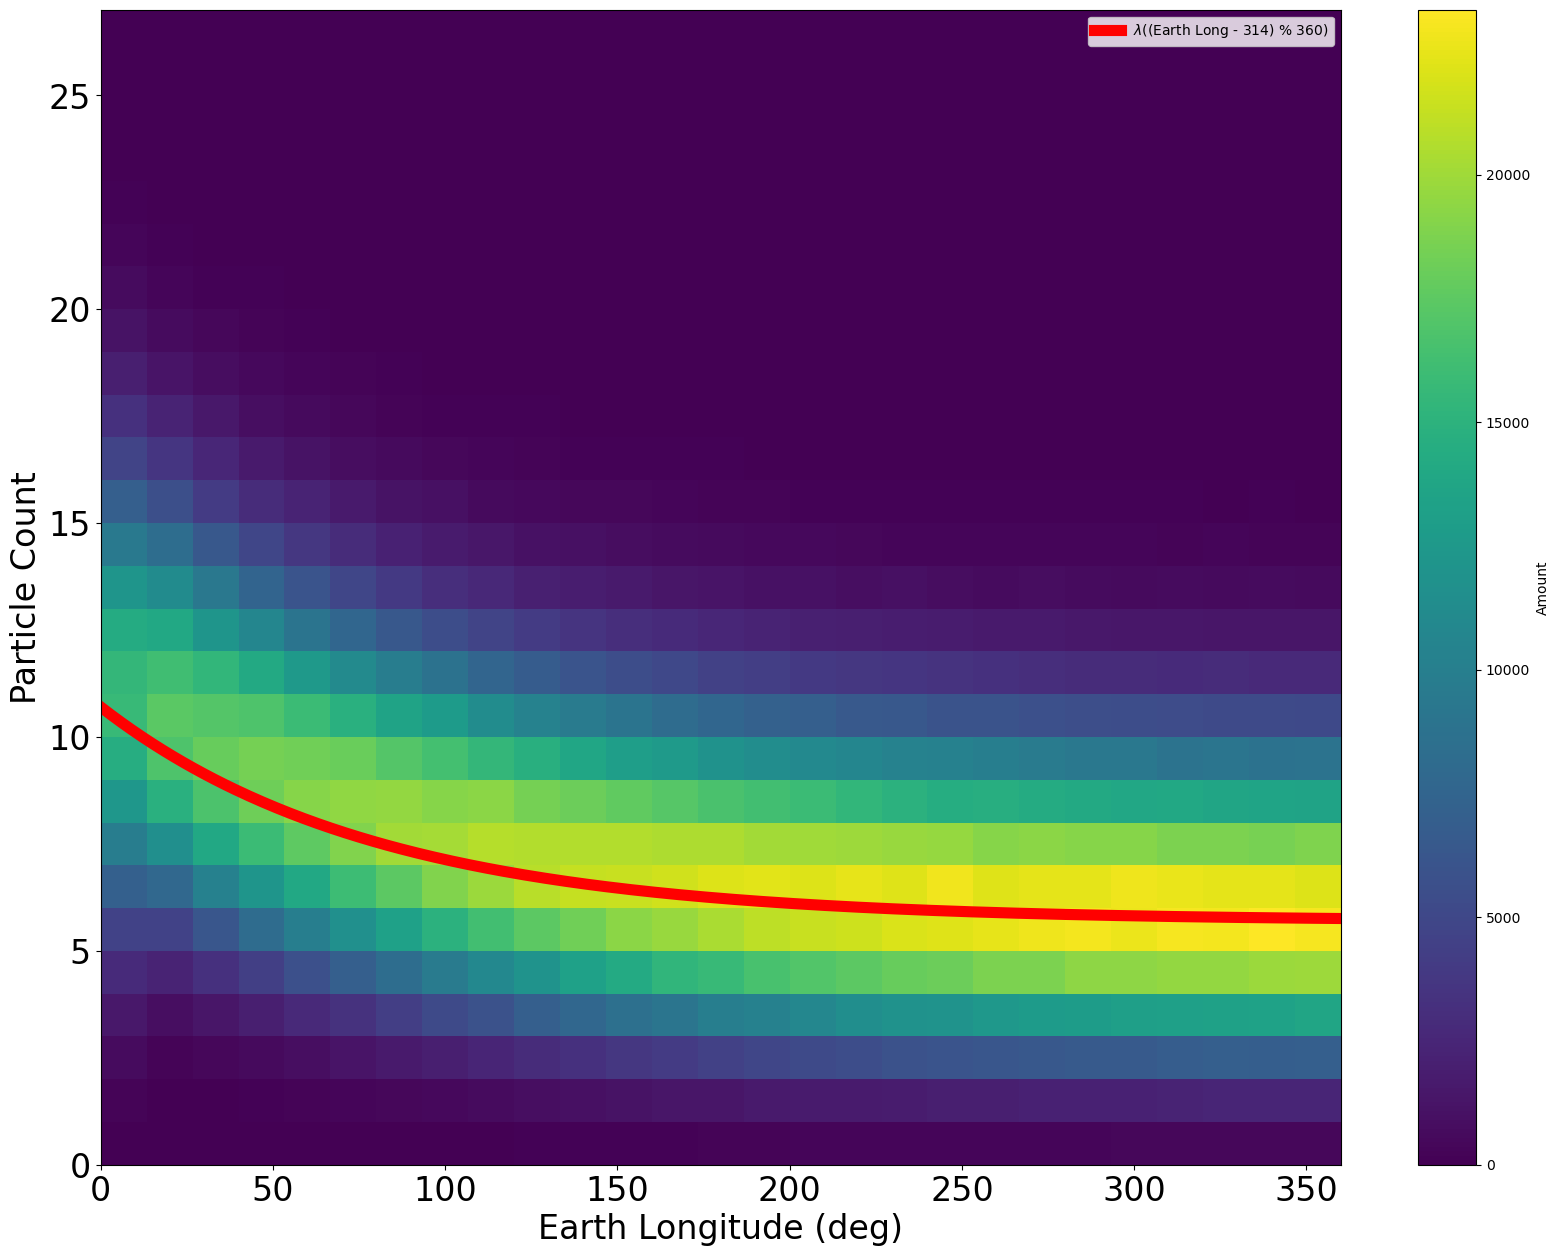

In [19]:
earth_long_cycle_4, num_particles_el_cycle_4 = get_subset(metadata[earth_long_idx,:], metadata, num_particles_idx, 0, 70*orbit_period)

earth_long_cycle_4 = (earth_long_cycle_4 - earth_long_cycle_repeat) % 360

xs_means = np.linspace(0, 360, 361)
means_exp = 5 * np.power(np.e, -(xs_means)/80) + 5.7

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(earth_long_cycle_4, num_particles_el_cycle_4, bins=27)
plt.plot(xs_means, means_exp, linewidth=8, color='r', label='$\lambda$((Earth Long - 314) % 360)')
plt.tick_params(labelsize=24)
plt.xlabel('Earth Longitude (deg)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.legend()
plt.show()

Now we have an equation for $\lambda$ in terms of the earth longitude, this equation is the following:

$$\lambda(L) = 5e^{-\frac{L}{80}} + 5.7$$

Now that we have our equation in terms of the earth longitude we will now convert it to be in terms of time.  Lets determine what the first time we have and what our value of the earth longitude is at that time:

In [20]:
print(f'First GPS time: {times[0]}')
print(f'First Earth Longitude: {metadata[earth_long_idx,0]}')

First GPS time: 940680016.0
First Earth Longitude: 45.0


Provided the two previous values we can construct an equation to convert from time to earth longitude.  First we will determine the position in the total orbital cycle: $(t - t_{start}) \% T_{orbit}$ where $t_{start}=940680016.0$ GPS seconds and $T_{orbit}=5400$ GPS seconds.

Now that we know where we are in the cycle, we can compute the fractional amount into the cycle we are at: $\frac{(t - t_{start}) \% T_{orbit}}{T_{orbit}}$.

With this fractional amount, we know that this will shift us some amount of degrees forward in the earth longitude cycle from the original amount of $\phi_{start}=45$.  We can compute what the current phase is in the following way: $\phi_{start} + 360 *\frac{(t - t_{start}) \% T_{orbit}}{T_{orbit}}$.

Now we can threshold this value to be in the range of 0 to 360 degrees: $L = (\phi_{start} + 360 *\frac{(t - t_{start}) \% T_{orbit}}{T_{orbit}}) \% 360$.

Now we have converted our background distributions parameter to be a function of time instead of earth longitude:

$$\lambda(t) = 5e^{-\frac{\bigg(\phi_{start} + 360 *\frac{\big(t - t_{start}\big) \% T_{orbit}}{T_{orbit}}\bigg) \% 360}{80}} + 5.7$$

Once again where $t_{start}=940680016.0$ GPS seconds, $\phi_{start} = 45$ degrees, and $T_{orbit}=5400$ GPS seconds.

Let's visualize our distribution parameter over a long period of time:

In [21]:
# lets define a function for our distribution
def cosmic_pdf_lambda(times):
    t_start = 940680016.0
    phi_start = 45
    T_orbit = 5400
    
    cycle_fraction = ((times - t_start) % T_orbit) / T_orbit
    
    longitude = (phi_start + (360 * cycle_fraction)) % 360
    
    lambdas = 5 * np.power(np.e, -(longitude)/80) + 5.7
    
    return lambdas

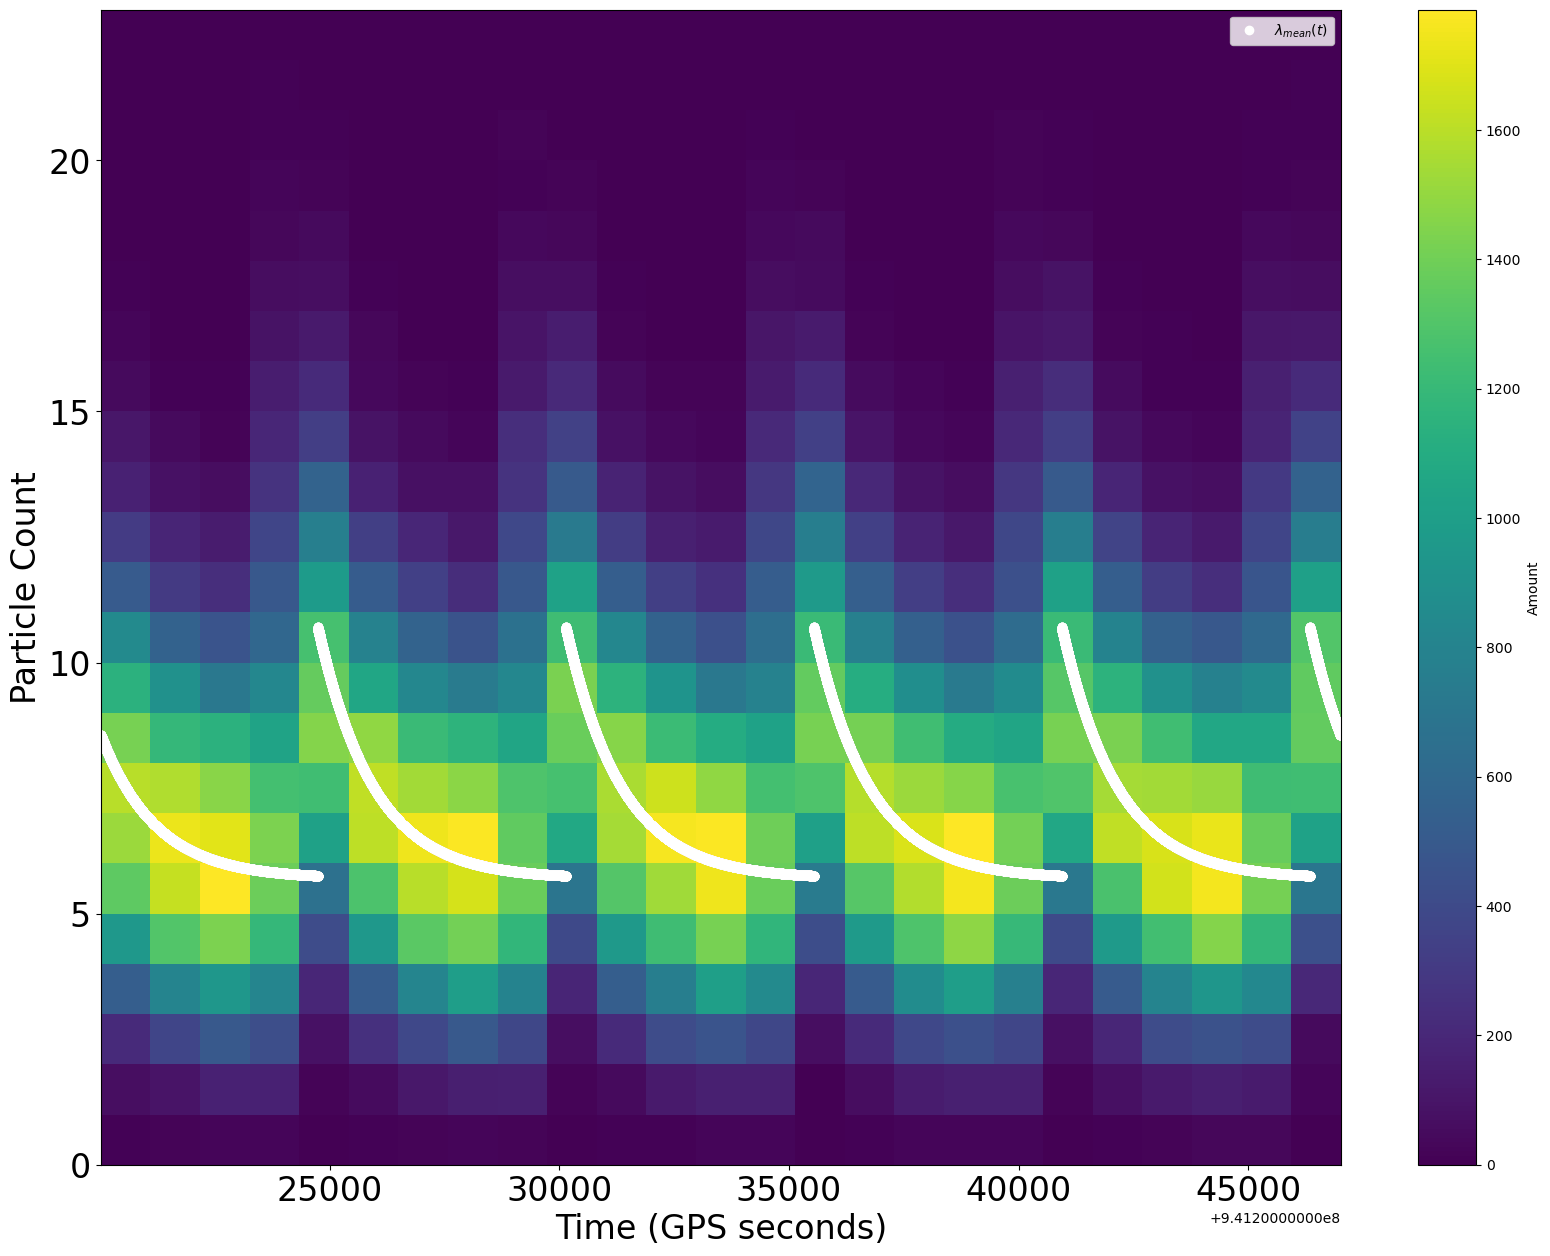

In [22]:
times_pdf_1, particle_counts_pdf_1 = get_subset(times, metadata, num_particles_idx, 100*orbit_period, 5*orbit_period)

cosmic_means = cosmic_pdf_lambda(times_pdf_1)

fig, ax = plt.subplots(1, 1)

hh = ax.hist2d(times_pdf_1, particle_counts_pdf_1, bins=25)
plt.plot(times_pdf_1, cosmic_means, 'wo', linewidth=8, label='$\lambda_{mean}(t)$')
plt.tick_params(labelsize=24)
plt.ylim(0, 23)
plt.xlabel('Time (GPS seconds)', fontsize=24)
plt.ylabel('Particle Count', fontsize=24)
plt.legend()

fig.colorbar(hh[3], ax=ax, label='Amount')
plt.show()

Comparing our model to the data we find that the model for $\lambda$ does a great job at predicting the mean value of particles detected at each point in time.  This in turn will lead to the Poisson distribution for the model being a good fit as the parameter for that model is closely fit to the true mean value of the data - with a time dependance.  Therefore at any given point in time, the true data at that point in time will be drawn from, approximately, the same distribution as a Poisson distribution with parameter $\lambda = 5e^{-\frac{\bigg(\phi_{start} + 360 *\frac{\big(t_{current} - t_{start}\big) \% T_{orbit}}{T_{orbit}}\bigg) \% 360}{80}} + 5.7$ where $t_{current}$ is the current time in GPS seconds that we are considering.

### Part 4

Let's explore how the 5-sigma threshold particle count changes as we view the data at different times.  Lets choose four times:

$$t_1 = t_{start} + (50 * T_{orbit})$$
$$t_2 = t_{start} + (50 * T_{orbit}) + (\frac{1}{3} * T_{orbit})$$
$$t_3 = t_{start} + (50 * T_{orbit}) + (\frac{2}{3} * T_{orbit})$$
$$t_4 = t_{start} + (51 * T_{orbit})$$

Once again where $t_{start}=940680016.0$ GPS seconds and $T_{orbit}=5400$ GPS seconds.

At each of these times we will answer the following statistical question:

> What particle count must I measure in order for the background distribution to have a probability of 5-sigma to have produced that signal?

We will first note that as we have periodic behavior in time we expect that value we find for $t_1$ should equal to the value we find for $t_4$.  Let's answer this question for the four different times chosen:

In [23]:
# helper function
def find_5sigma_poisson(lambda_):
    # define the sigma value
    sigma = 5

    # determine the probability associated with this sigma
    prob_sigma = stats.norm.sf(sigma, loc=0, scale=1)

    # use the inverse survival function to determine the value that has the same associated probability
    value = stats.poisson.isf(prob_sigma, lambda_)

    return value

# constants
t_start = 940680016.0
T_orbit = 5400

# define the times 
t1 = t_start + (50 * T_orbit)
t2 = t_start + (50 * T_orbit) + ((1/3) * T_orbit)
t3 = t_start + (50 * T_orbit) + ((2/3) * T_orbit)
t4 = t_start + (51 * T_orbit)

# compute the lambdas
lambda1 = cosmic_pdf_lambda(t1)
lambda2 = cosmic_pdf_lambda(t2)
lambda3 = cosmic_pdf_lambda(t3)
lambda4 = cosmic_pdf_lambda(t4)

# find the 5-sigma particle counts
count1 = find_5sigma_poisson(lambda1)
count2 = find_5sigma_poisson(lambda2)
count3 = find_5sigma_poisson(lambda3)
count4 = find_5sigma_poisson(lambda4)

# print the results
print(f'A particle count of {count1} is required for a 5-sigma probability at time {t1}, at which lambda = {lambda1}')
print(f'A particle count of {count2} is required for a 5-sigma probability at time {t2}, at which lambda = {lambda2}')
print(f'A particle count of {count3} is required for a 5-sigma probability at time {t3}, at which lambda = {lambda3}')
print(f'A particle count of {count4} is required for a 5-sigma probability at time {t4}, at which lambda = {lambda4}')

A particle count of 27.0 is required for a 5-sigma probability at time 940950016.0, at which lambda = 8.548914123654615
A particle count of 22.0 is required for a 5-sigma probability at time 940951816.0, at which lambda = 6.335678664660178
A particle count of 21.0 is required for a 5-sigma probability at time 940953616.0, at which lambda = 5.8418390822485655
A particle count of 27.0 is required for a 5-sigma probability at time 940955416.0, at which lambda = 8.548914123654615


As expected, we see that the number of particles required for a 5-sigma event changes as we vary the time.  This is because the parameter to our Poisson - $\lambda$ - is time dependent.  It is of note that if we offset a full period from a specific time we find that the number of particles required for a 5-sigma detection is the same - this is specifically seen with $t_1$ and $t_4$.  Below we present the same data but in a table to make it more readable:

| Time (GPS Seconds)        | Particle Count required for a 5-sigma probability    |
|--------------|-----------|
| 940950016.0 |    27   |
| 940951816.0 |    22   |
| 940953616.0 |    21   |
| 940955416.0 |    27   |

In [24]:
hf.close()

## Problem 2

Now let's look at a stack of telescope images.  Within these images we will be looking for the faintest stars.

### Part 1

First lets download and load the data into our notebook:

In [25]:
# first lets load our data
hf = h5py.File('images.h5', 'r')
imagestack = np.array(hf.get('imagestack'))

### Part 2

Now explore our data.  We will begin by visualizing all 10 of the images taken:

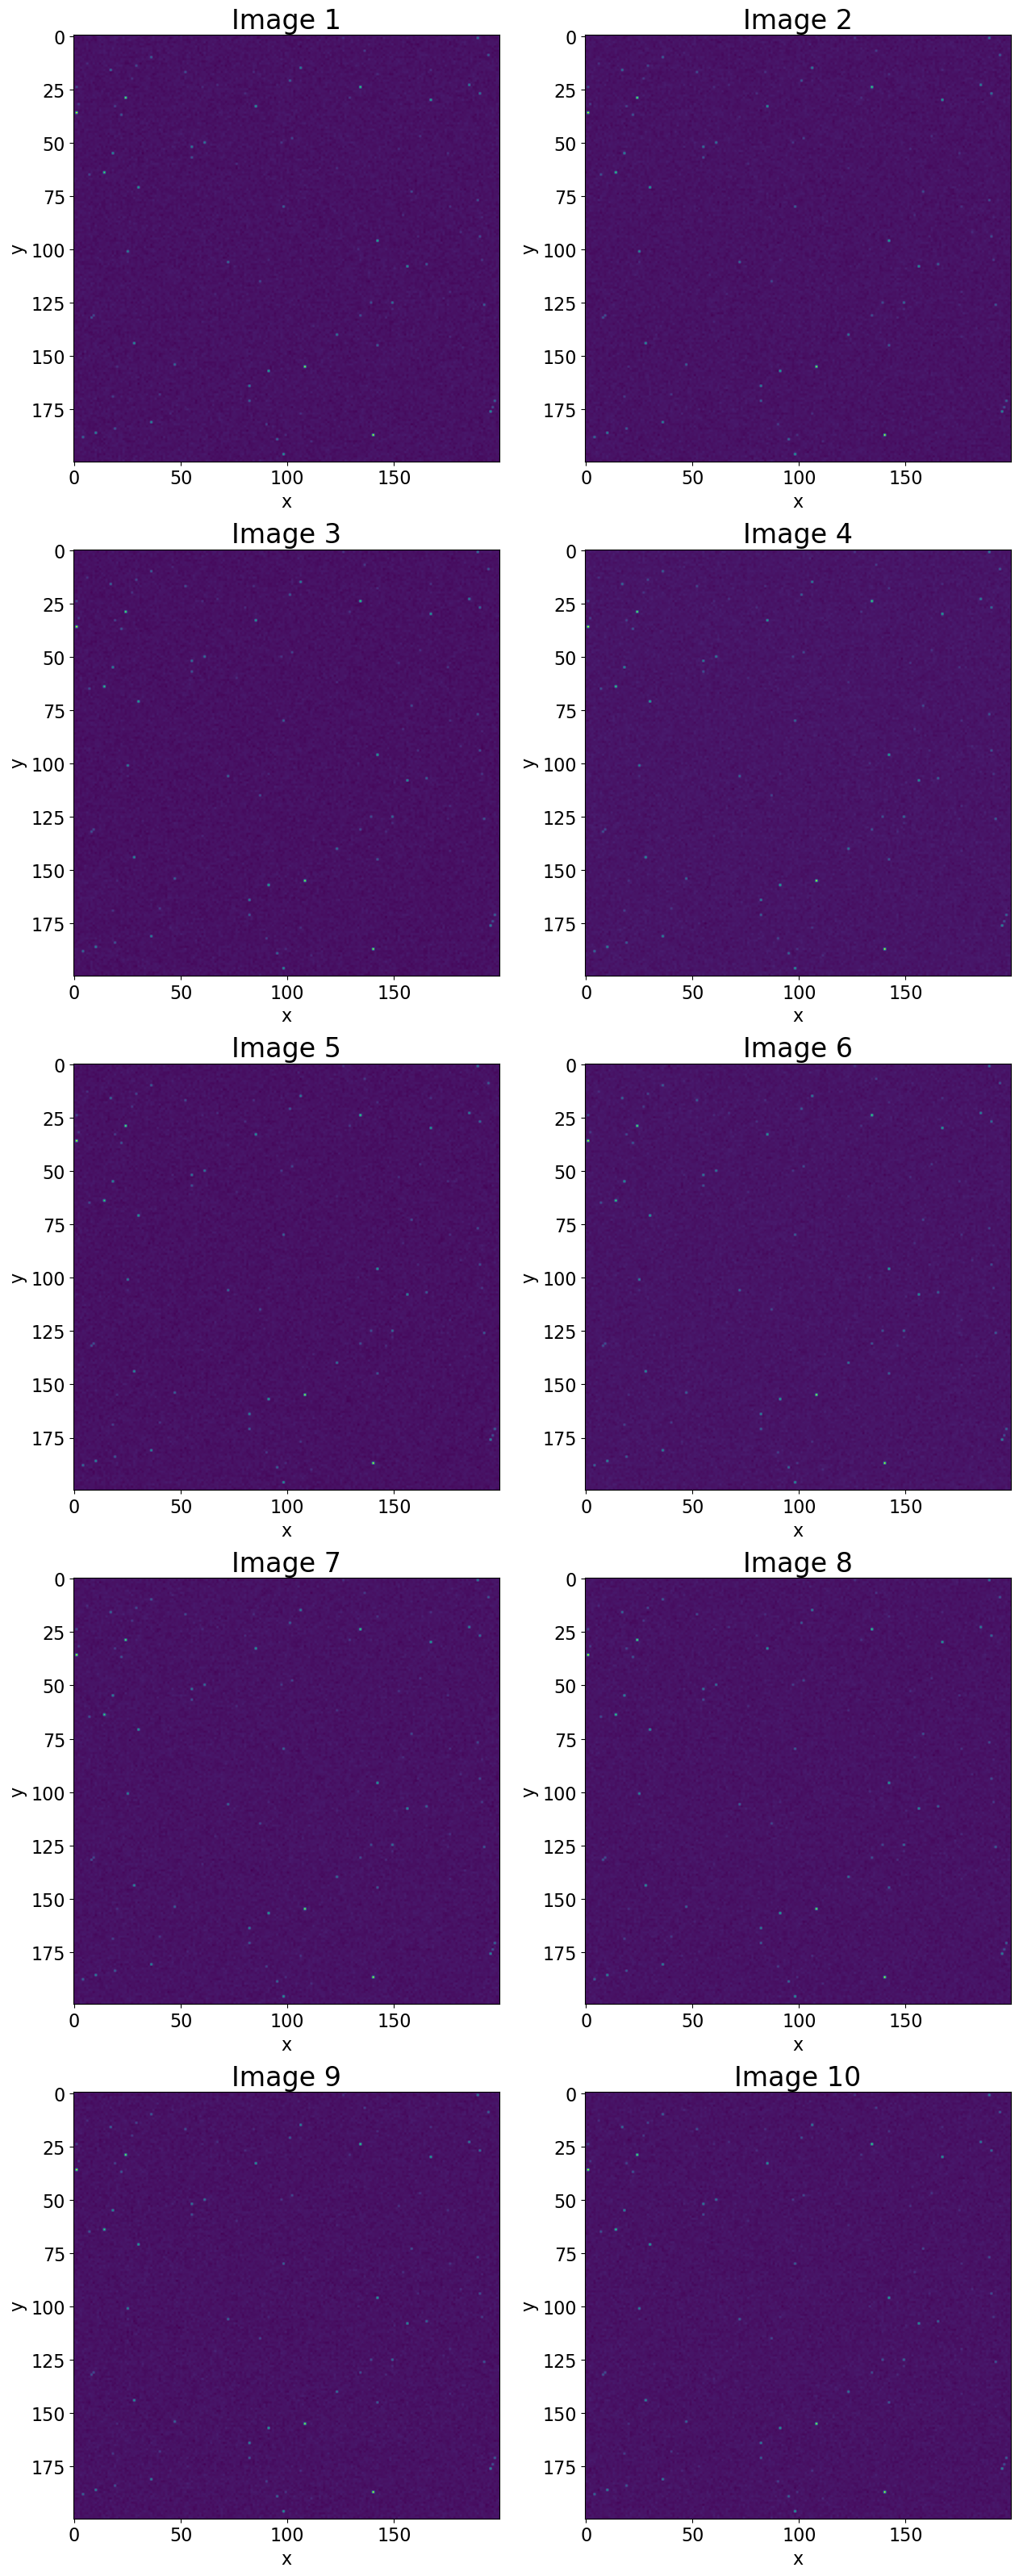

In [26]:
plt.rcParams["figure.figsize"] = (15,40)

for i in range(0, 10):
    plt.subplot(5, 2, i+1)
    
    plt.title(f'Image {i+1}', fontsize=24)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.tick_params(labelsize = 16)
    plt.imshow(imagestack[:,:,i])

plt.show()

In addition, let's plot the sum of all of the images as well as the average of all of the images.

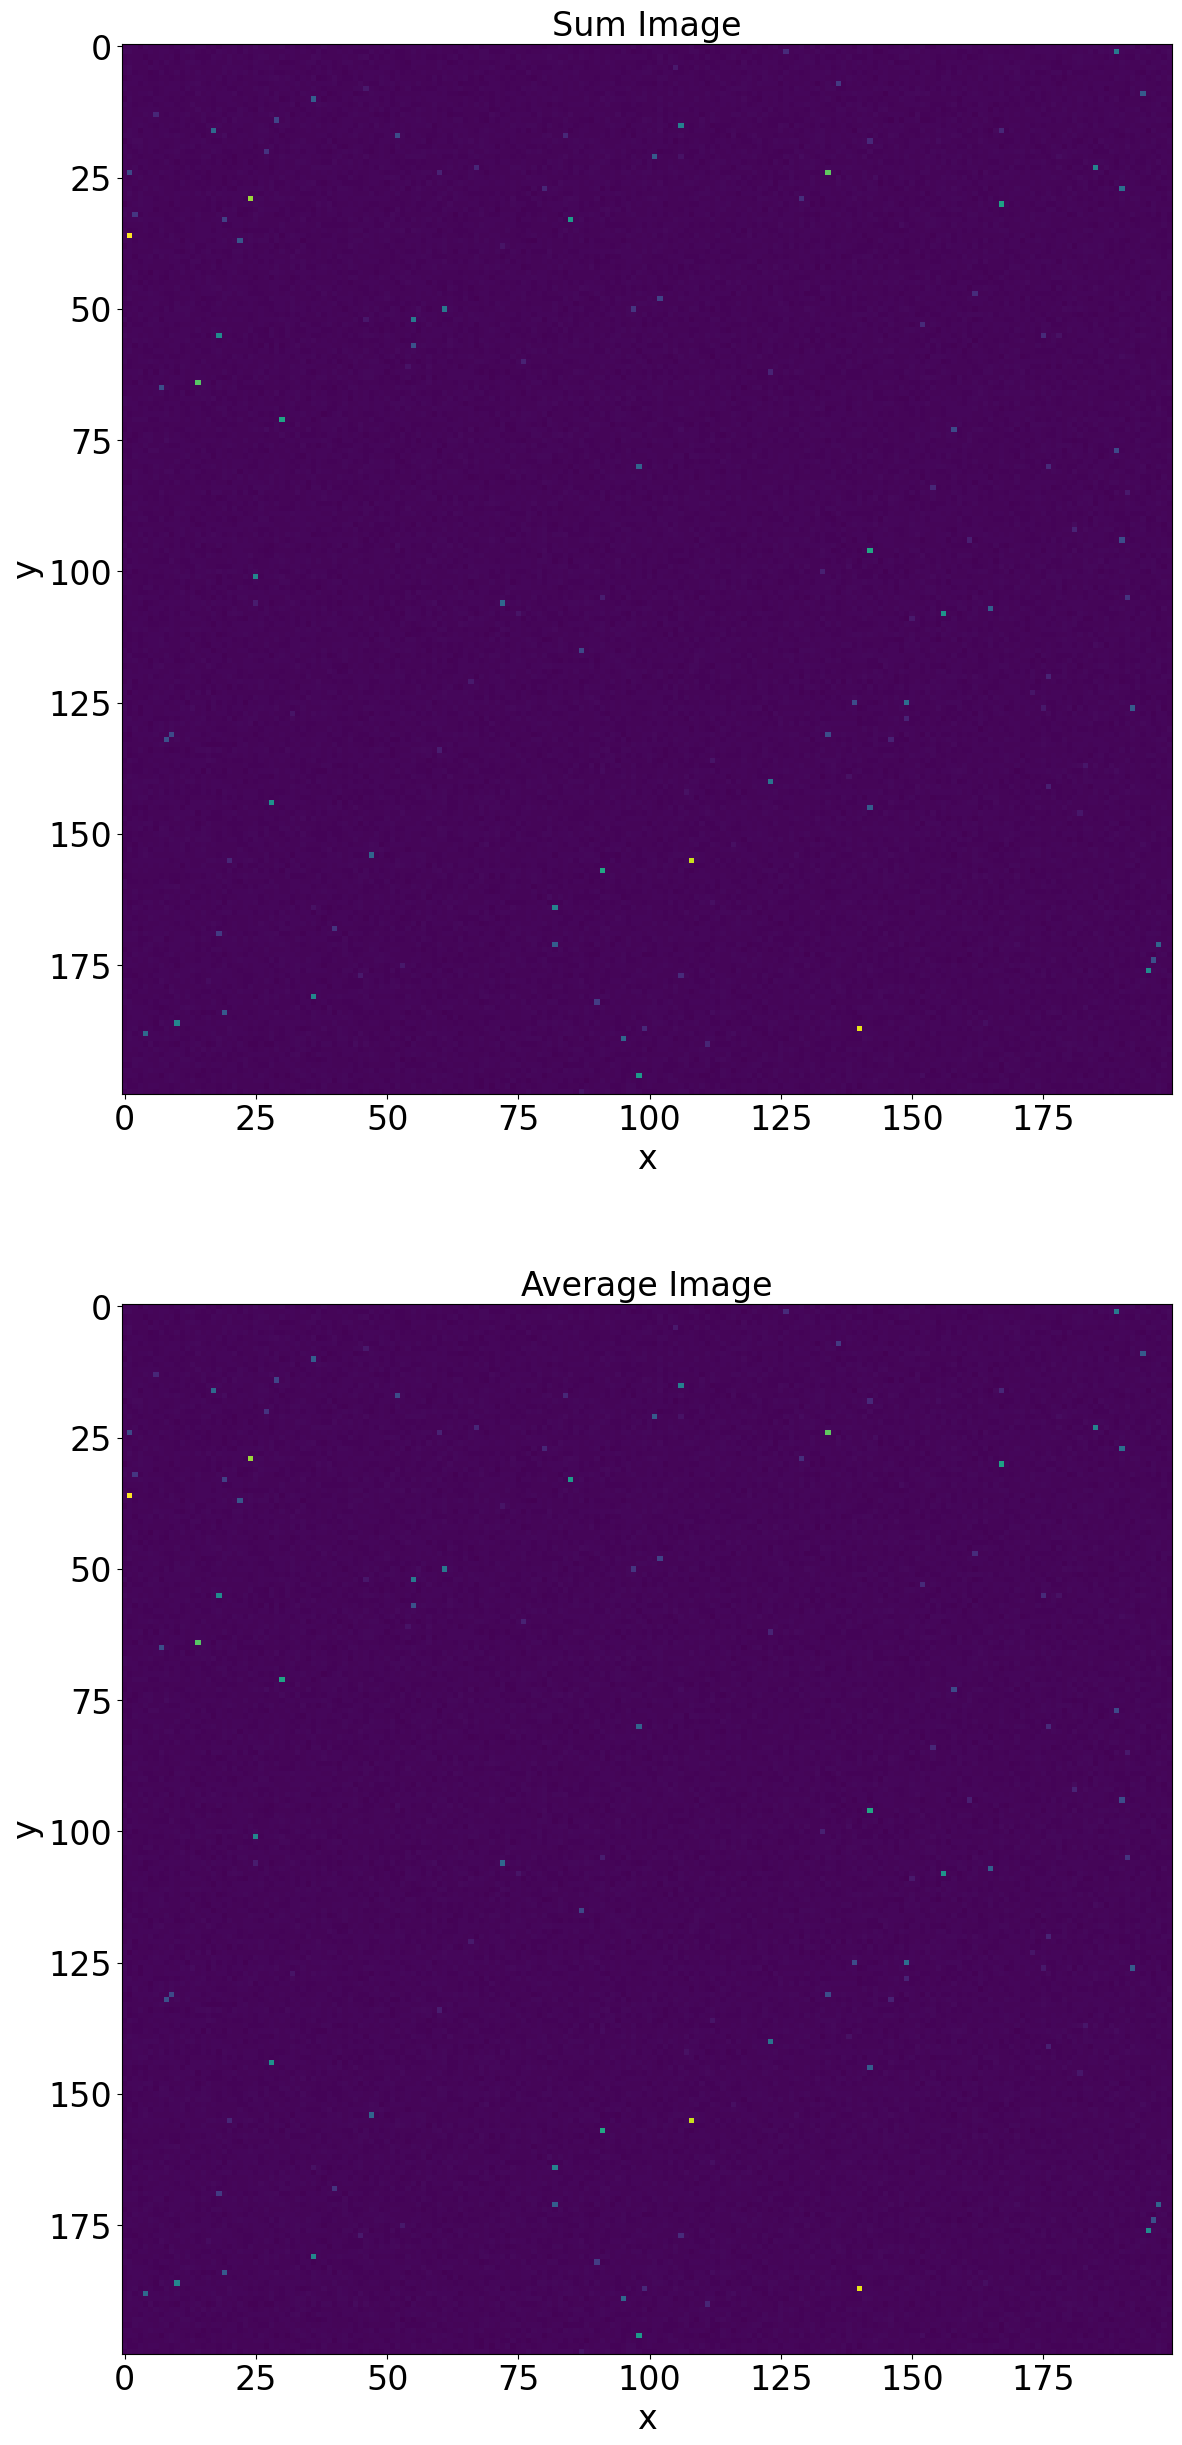

In [27]:
sum_image = imagestack[:,:,0]

for i in range(1, 10):
    sum_image += imagestack[:,:,i]
    
average_image = sum_image / 10

plt.rcParams["figure.figsize"] = (20,30)

plt.subplot(2, 1, 1)
plt.title("Sum Image", fontsize=24)
plt.ylabel('y', fontsize=24)
plt.xlabel('x', fontsize=24)
plt.tick_params(labelsize = 24)
plt.imshow(sum_image)

plt.subplot(2, 1, 2)
plt.title("Average Image", fontsize=24)
plt.ylabel('y', fontsize=24)
plt.xlabel('x', fontsize=24)
plt.tick_params(labelsize = 24)
plt.imshow(average_image)
plt.show()

Within the above images we have noise and stars.  One of the images will contain a transient event.  Thus each pixel in the image corresponds to an intensity for that point in the sky, because of this we can compute the intensity at a single pixel as $I_{pixel}=I_{noise}+I_{star}+I_{transient}$ - where $I_{star}$ is generally zero and $I_{transient}$ is nearly always zero as the transient event is very rare.  To get a better idea of what the noise looks like lets subtract one image from another.  This operation will eliminate the possible star's intensity from the value at each pixel however the transient behavior may still be observed. 

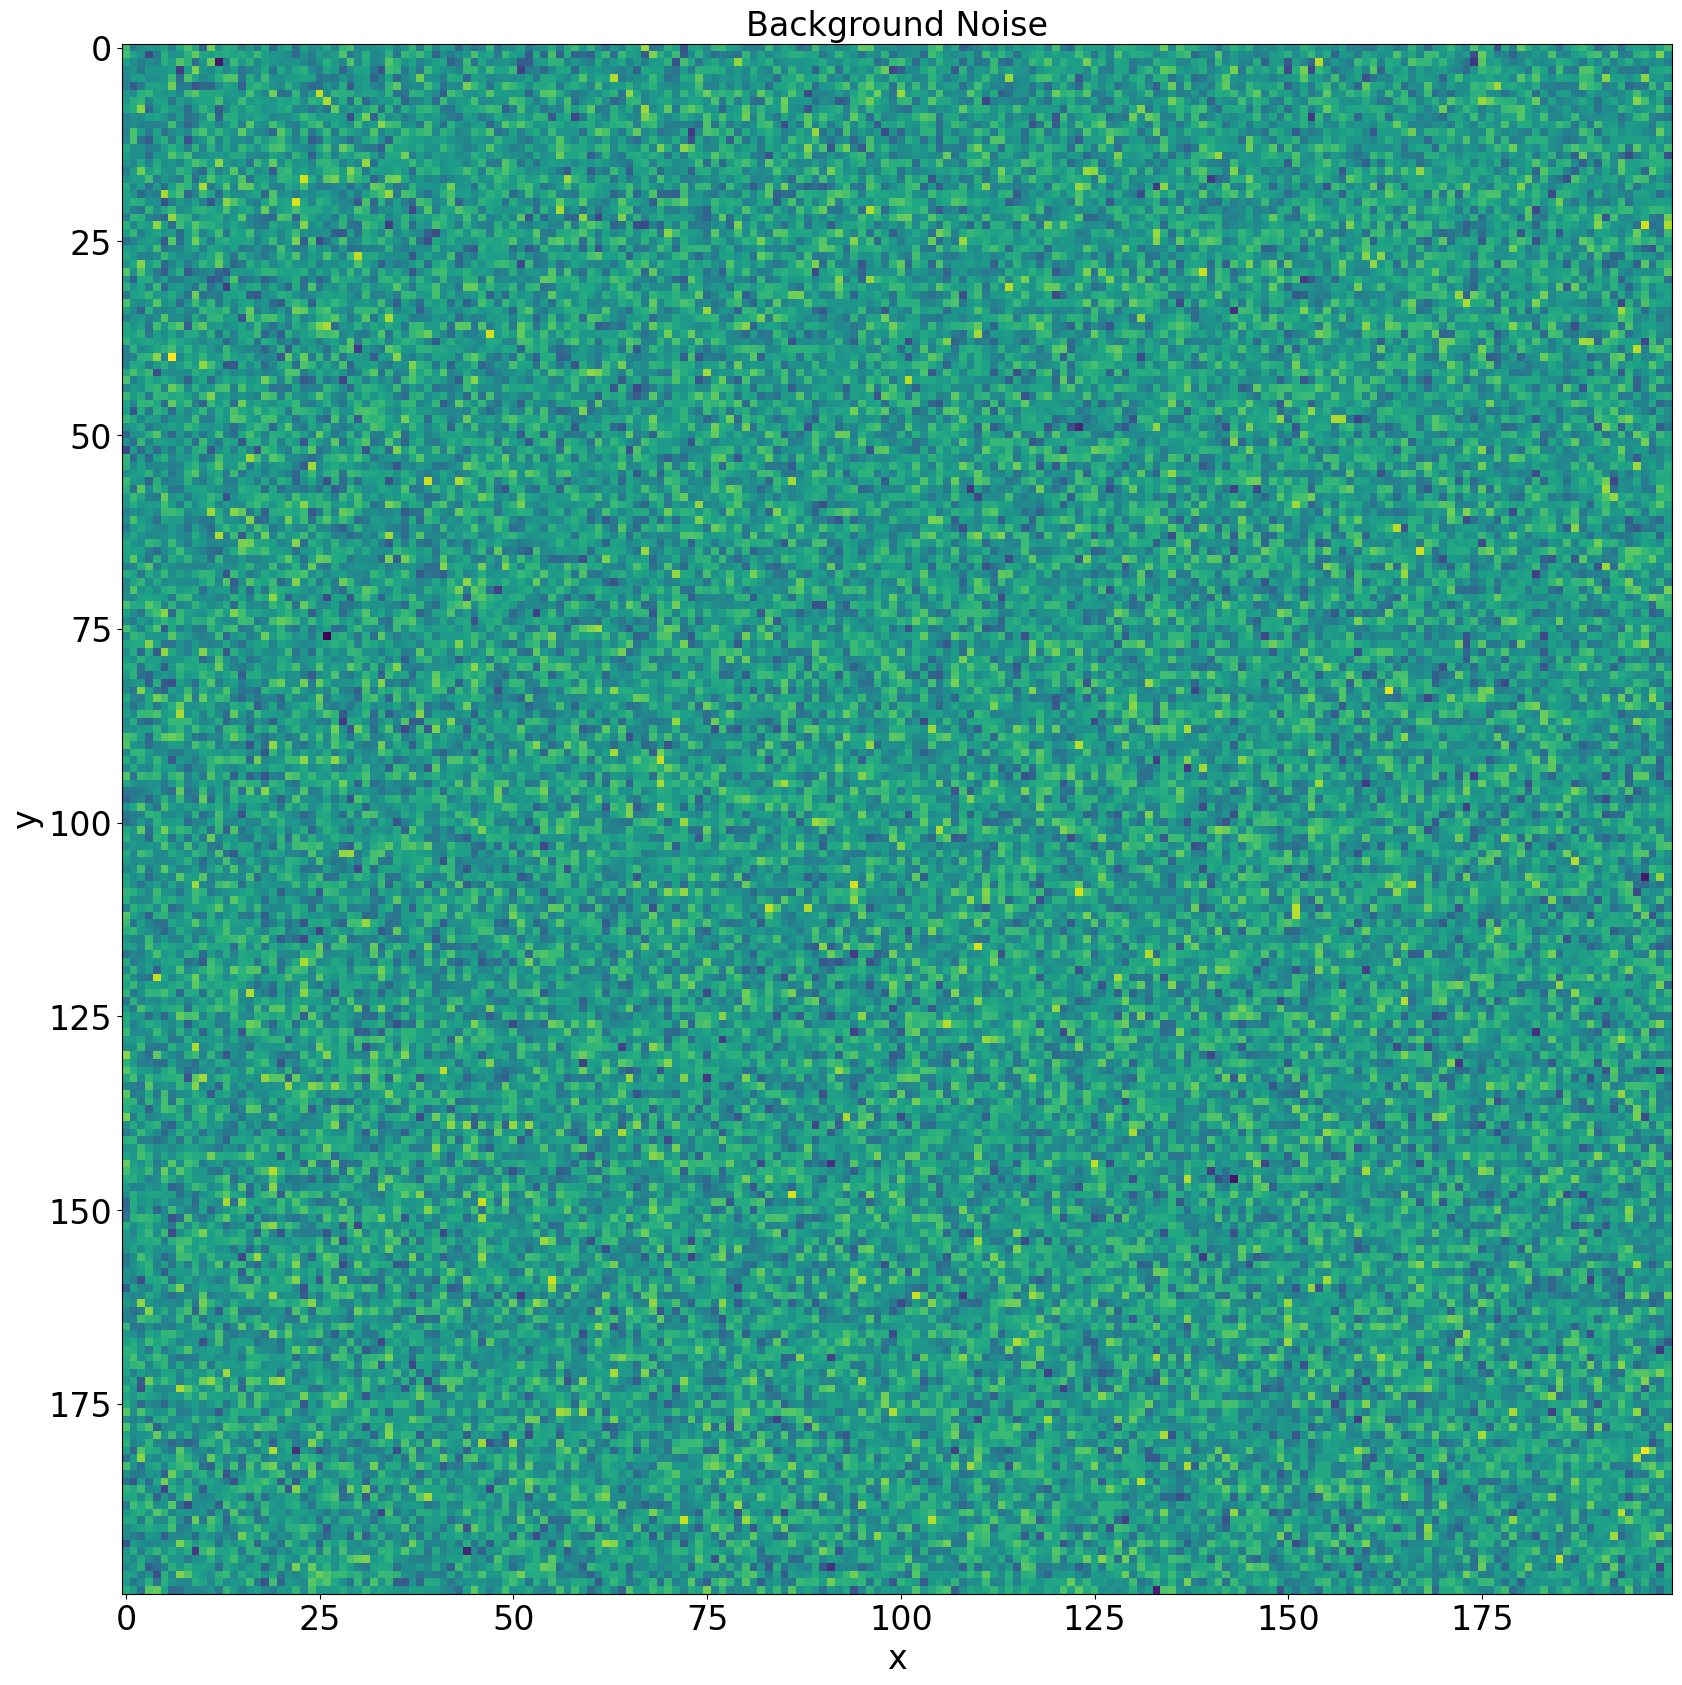

In [28]:
noise_image = imagestack[:,:,6]-imagestack[:,:,7]

plt.title("Background Noise", fontsize=24)
plt.ylabel('y', fontsize=24)
plt.xlabel('x', fontsize=24)
plt.tick_params(labelsize = 24)
plt.imshow(noise_image)
plt.show()

After exploring the data we can draw the following conclusions: first, there is no signal contamination in our images.  We see that the sum image does not have any strange defects throughout the image which allows us to draw this conclusion.   Next we can conclude that the data is consistent spatially from the same summed image as we do not see any double images of stars.  Also, we do not see any spatial dependence in the background distribution because the null space of the average and sum images does not fluctuate in in brightness range as we look at different locations within the image (i.e., the mean and standard deviation of the unknown background distribution are not changing with respect to the position in the image).  Thus each image taken by telescope is pointed at the same location in the sky.  Finally, we can conclude that the background is not time dependent.  This conclusion is drawn for two reasons: we do not have signal contamination and we know that the cosmic microwave background radiation - which is what is likely our background here - does not vary in time.

In order to determine the PDF of our background noise, we will create a histogram from one image and then we will proceed to fit a pdf's distribution to that histogram when viewing it on a semi-log scale.  We can, however, initially say that we expect our distribution to be continuous as our intensities are floating point values.  Lets create a histogram using the pixel intensities in image seven:

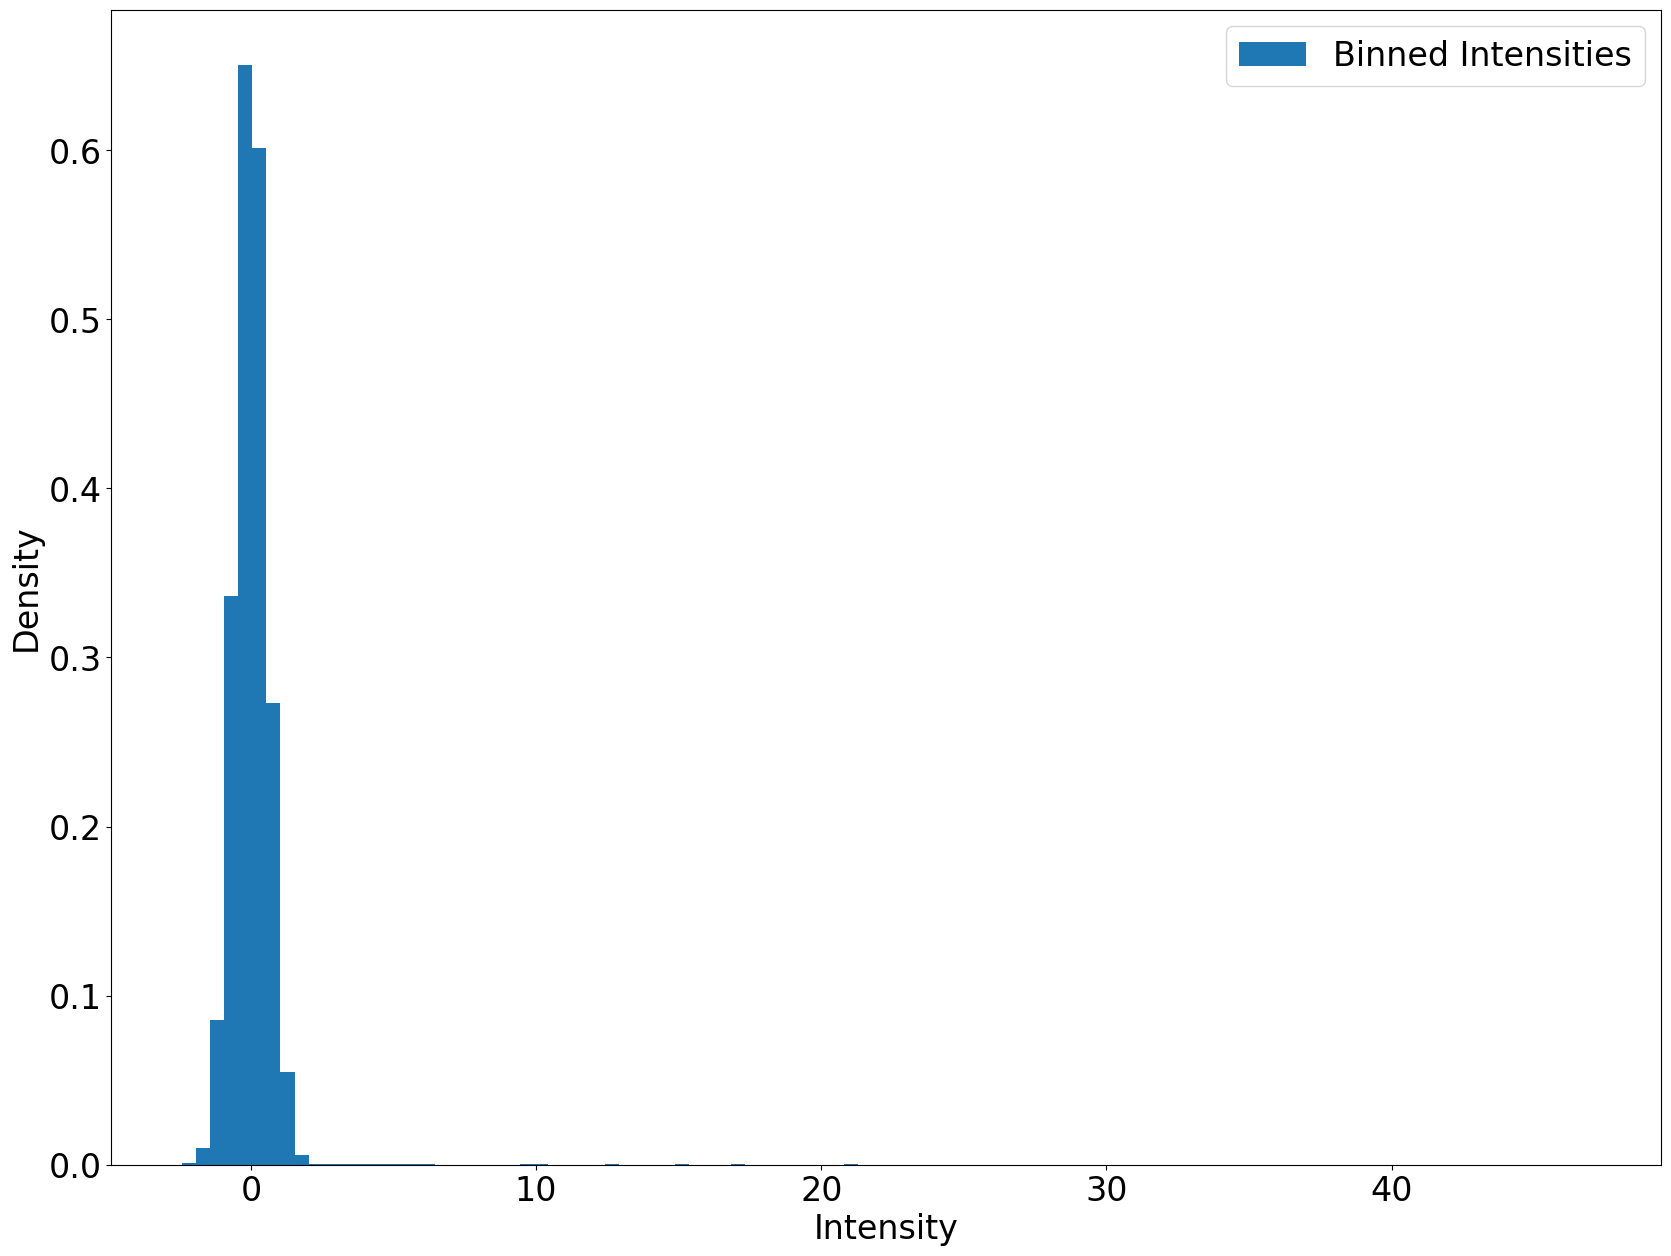

In [29]:
# this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

# first flatten the image into a 1D array
image7_flattened = np.reshape(imagestack[:,:,6], 200*200)

# next split these values into bins for a histogram and plot
fig, ax = plt.subplots(1, 1)
ax.hist(image7_flattened, 100, density=True, label="Binned Intensities")
plt.tick_params(labelsize = 24)
plt.xlabel('Intensity', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.legend(fontsize=24)
plt.show()

Let's view this plot on a semi-log scale:

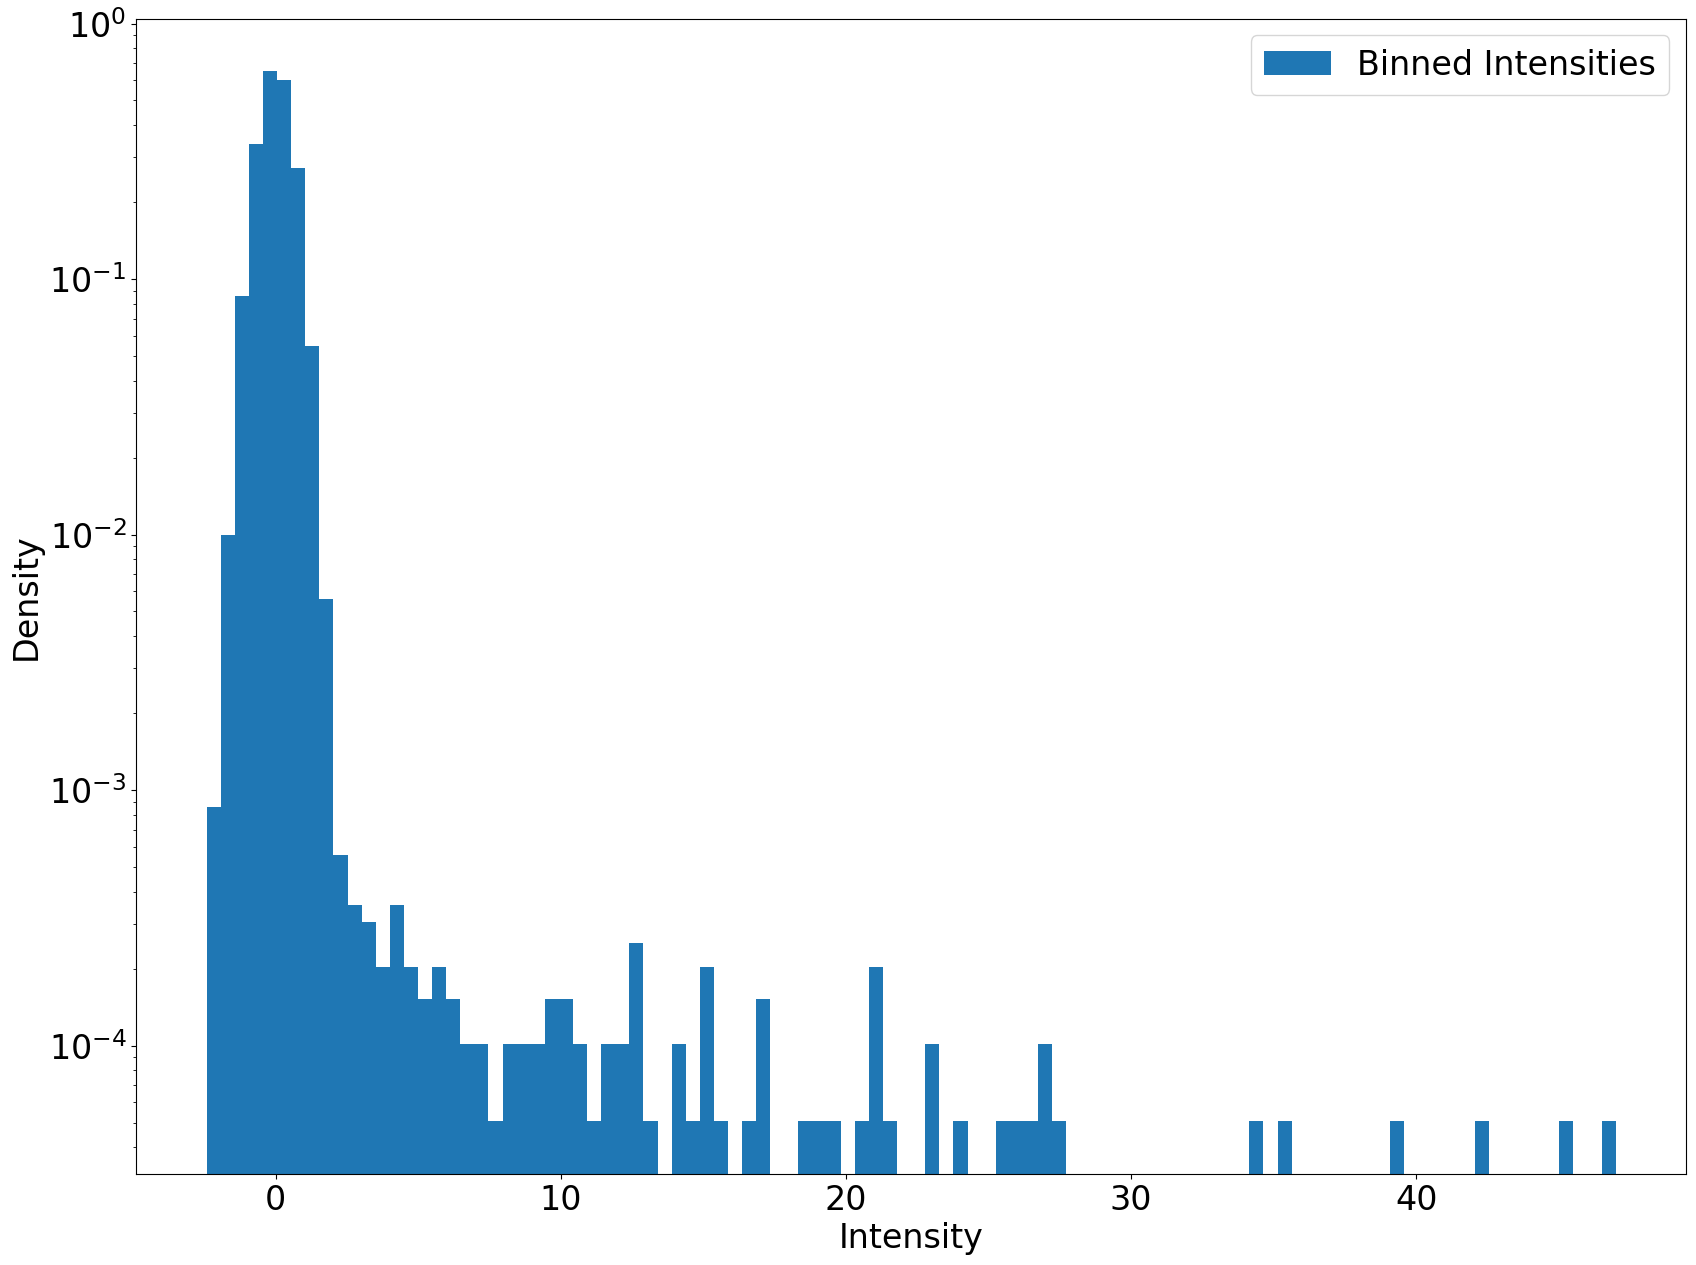

In [30]:
# plot the histogram
fig, ax = plt.subplots(1, 1)
ax.hist(image7_flattened, 100, density=True, label="Binned Intensities")
plt.tick_params(labelsize = 24)
plt.yscale('log')
plt.xlabel('Intensity', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.legend(fontsize=24)
plt.show()

Above we see that values next to zero are the most common and then we have a tail that goes off in the positive direction.  This tail is due to the intensities of the individual stars in our image.  To determine a model for our background noise distribution we will look around zero as we know that the majority of the values for an individual image are from the background.  From the above histogram we can also see that our background distribution appears to be centered about zero and that the distribution can go to negative values.  This eliminates the exponential and Rayleigh distribution.  Additionally, we see that our distribution appears to be continuous.  Let's try fitting a Gaussian to the above histogram after we zoom in to have a better view of the data around zero - the noise data that we are trying to fit:

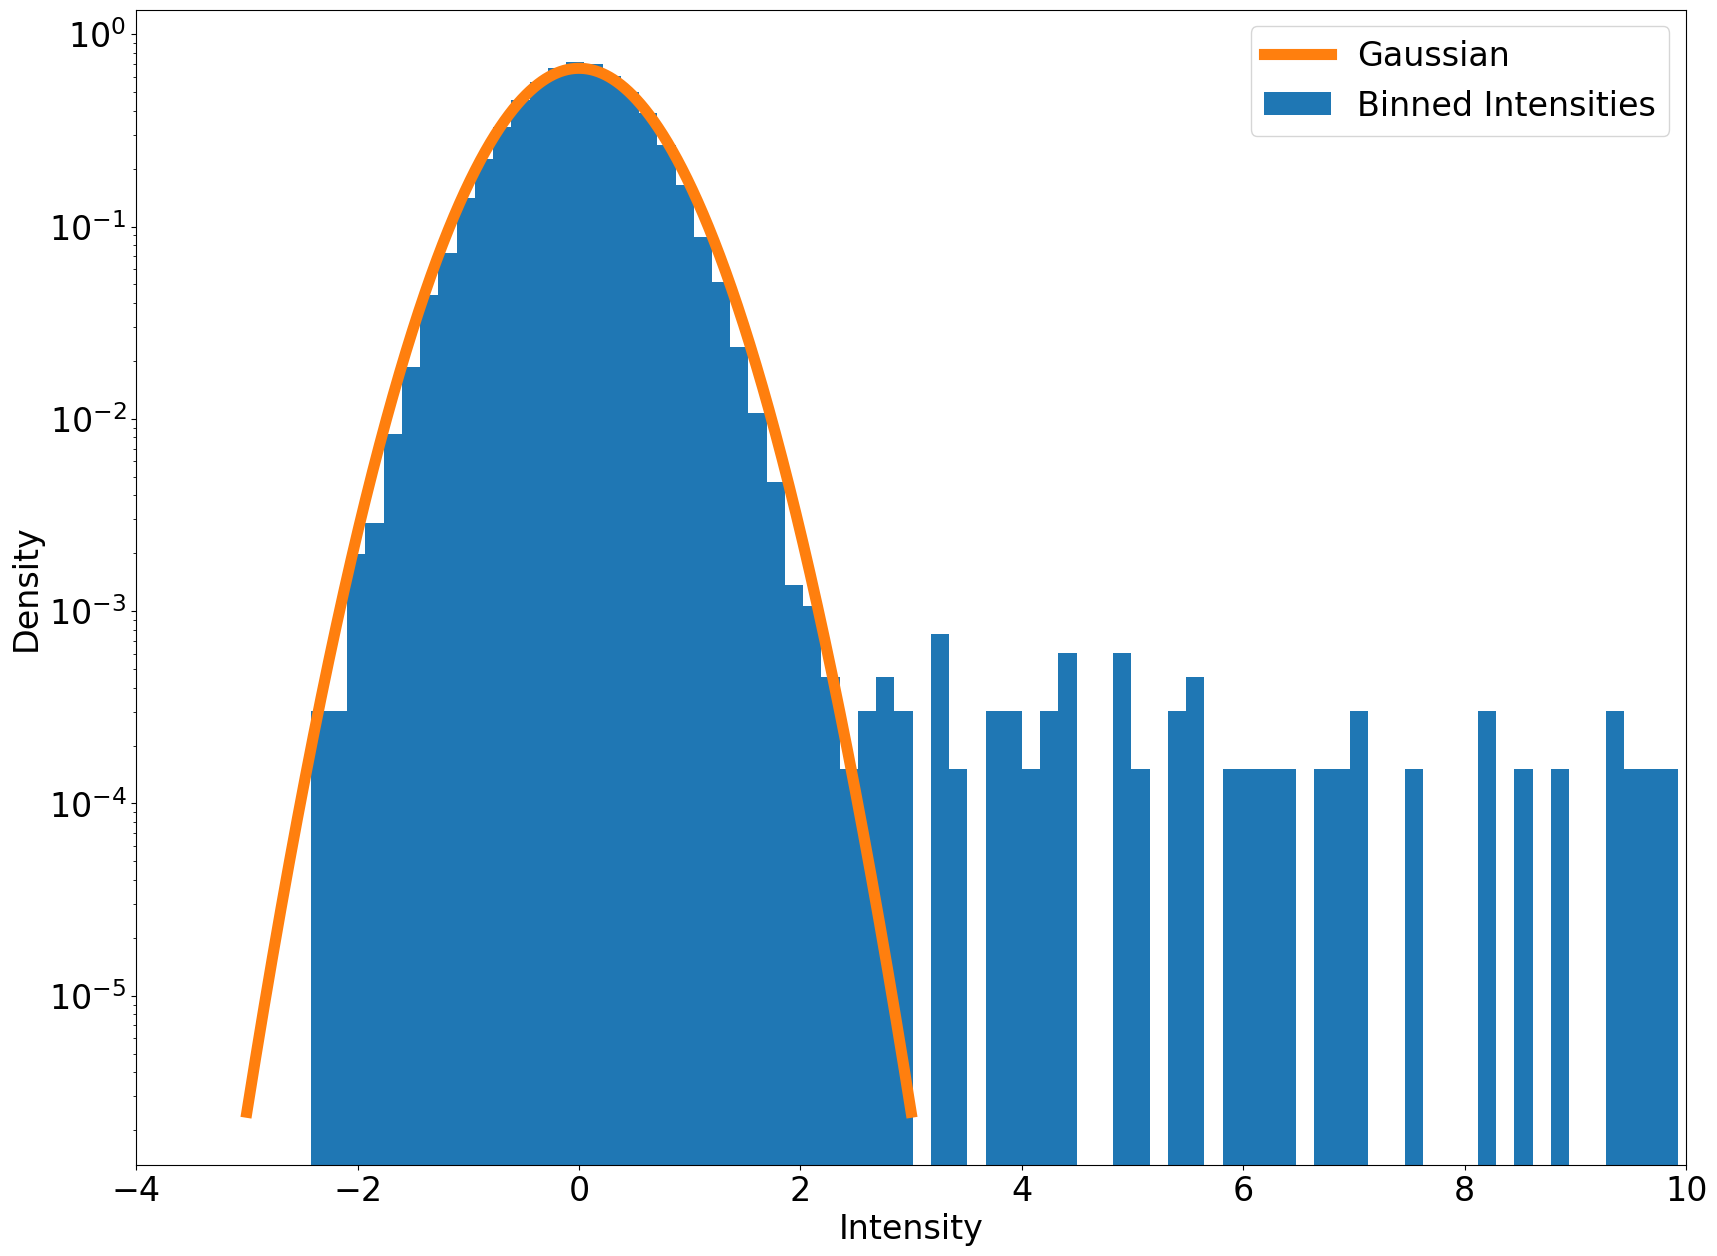

In [31]:
# fit the gaussian
gaus_xs = np.linspace(-3, 3, 3000)
gaus_ys = stats.norm.pdf(gaus_xs, loc=0, scale=0.6)

# plot the histogram and the gaussian
fig, ax = plt.subplots(1, 1)
ax.hist(image7_flattened, 300, density=True, label="Binned Intensities")
plt.plot(gaus_xs, gaus_ys, linewidth=8, label="Gaussian")
plt.tick_params(labelsize = 24)
plt.yscale('log')
plt.xlabel('Intensity', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xlim(-4, 10)
plt.legend(fontsize=24)
plt.show()

Now we can conclude the background distribution for the noise in our images: a Gaussian distribution with mean 0 and standard deviation 0.6.  As an equation:

$$\text{pdf}_{noise}(x) = \frac{1}{\sqrt{2\pi * 0.6^2}} e^{-\frac{x^2}{2*0.6^2}}$$

### Part 3

Now that we have our background distribution for a single image (a Gaussian with parameters mean=0, std=0.6), we can begin to search for faint stars in our images.  As the faint stars are exactly that - faint - we cannot simply consider one image when we are searching for them.  Rather we will consider the average image and count all of the intensities above or equal to the intensity that corresponds to a 5-sigma intensity.  The background distribution for our problem thus becomes the average of 10 Gaussian distributions where each individual Gaussian has mean=0 and std=0.6.  Thus the question we are trying to ask is the following:

> What intensity must we have measured in order for the background distribution, an average of 10 Gaussians distributions (mean=0, std=0.6), to have a 5-sigma probability to have produced that intensity?

To determine how many faint stars are detected we must first answer the above question.  Once we have done that we know that any intensity above the 5-sigma intensity can be considered a star.  This will give us the total number of stars in the average image.  However to get the total number of _faint_ stars we must know how many stars are detected in a single image - as faint stars will not be detected in a single image.  To determine the number of stars detected in a single image - where the background is a Gaussian of mean=0 and std=0.6 as previously found - we will answer the following question:

> What intensity must we have measured in order for the background distribution, a Gaussians distribution (mean=0, std=0.6), to have a 5-sigma probability to have produced that intensity?

This value will provide a threshold intensity in order to consider if a pixel corresponds to a star in a single image.  

Now with these two values we can evaluate the following equation to determine the number of faint stars detected in the region of the sky which we are taking images of:

$$N_{faint} = N_{\text{stars in average image}} - N_{\text{stars in one image}} - 1$$ 

Where the $-1$ is added to remove the transient event.

Lets compute the two threshold values and then compute the total number of faint stars - note that we must first compute the background distribution for the first statistical question but this distribution is exactly a Gaussian with mean=0 and standard deviation $\frac{0.6}{\sqrt{10}}$:

In [32]:
# helper function
def find_5sigma_gaussian(mean, std):
    # define the sigma value
    sigma = 5

    # determine the probability associated with this sigma
    prob_sigma = stats.norm.sf(sigma, loc=0, scale=1)

    # use the inverse survival function to determine the value that has the same associated probability
    value = stats.norm.isf(prob_sigma, loc=mean, scale=std)

    return value

# compute and print the intensity thresholds
image_intensity_threshold = find_5sigma_gaussian(0, 0.6)
avg_intensity_threshold = find_5sigma_gaussian(0, 0.6/np.sqrt(10))
print(f'The threshold intensity for an image is: {image_intensity_threshold}')
print(f'The threshold intensity for the average of 10 images is: {avg_intensity_threshold}')

# now lets count the number of stars in a single image
N_stars_one_image = np.count_nonzero(image7_flattened > image_intensity_threshold)
N_stars_avg_image = np.count_nonzero(np.reshape(average_image, 200*200) > avg_intensity_threshold)
N_faint_stars = N_stars_avg_image - N_stars_one_image - 1

# print the results for the star counts
print(f'The number of stars detected in a single image is: {N_stars_one_image}')
print(f'The number of stars detected in the average image is: {N_stars_avg_image}')
print(f'The number of faint stars detected is: {N_faint_stars}')

The threshold intensity for an image is: 3.0000000000000004
The threshold intensity for the average of 10 images is: 0.9486832980505139
The number of stars detected in a single image is: 97
The number of stars detected in the average image is: 125
The number of faint stars detected is: 27


From the above results we find that the total number of faint stars in the images is $27$ stars.  These stars were not significant enough in the base distribution to be considered stars but when we shifted to the average distribution we found that they became significant enough to be considered a star.   The reason they became significant enough to be considered a star is because when we moved to the average distribution, our 5-sigma intensity dropped from 3 to 0.9486 which enabled us to detect fainter stars while still not considering the background as faint stars.

### Part 4

In this portion of the lab, my lab partner and I found different distributions overall distribution used to answer our main statistical question.  The difference in our overall distribution (mine being the average of 10 Gaussian distributions of mean=0, std=0.6) is directly due to us asking different statistical questions.  Although we used the same data, I was interested in finding faint stars in the images while they were interested in locating a transient event in one of the images.  To answer each of our questions we had to determine a different method in order to construct a PDF that eliminated data that would obstruct their reading - them having to remove normal stars from their background and me having to remove the transient event from mine.

In [33]:
hf.close()